In [ ]:
import requests
import xml.etree.ElementTree as ET
import random
import re
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch.nn as nn
import torch.nn.functional as F
import re
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import requests
import xml.etree

def fetch_arxiv_data(query, max_results, label):
    """
    arXiv API ile belirtilen kategoriden 'max_results' kadar makale özetini çekip
    (özet, etiket) şeklinde bir liste döndürür.
    """
    url = f"http://export.arxiv.org/api/query?search_query={query}&start=0&max_results={max_results}"
    response = requests.get(url)
    root = ET.fromstring(response.content)
    summaries = []

    for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
        summary_el = entry.find('{http://www.w3.org/2005/Atom}summary')
        if summary_el is not None:
            summary_text = summary_el.text.strip()
            summaries.append((summary_text, label))

    return summaries

# 400 article from each category 400, 1200 totally
ai_articles = fetch_arxiv_data("cat:cs.AI",  400, "AI")
ec_articles = fetch_arxiv_data("cat:q-fin.EC", 400, "ECON")
ps_articles = fetch_arxiv_data("cat:cs.SI", 400, "PSY")

#Combine in a list
data = ai_articles + ec_articles + ps_articles


print("Total Article:", len(data))

Total Article: 1200


In [ ]:
print("AI Article:", len(ai_articles))
print("ECON Article:", len(ec_articles))
print("PSY Article:", len(ps_articles))


AI Article: 400
ECON Article: 400
PSY Article: 400


In [ ]:
#Save the data
import pickle

# Save the fetched data into a pickle file
output_file_path = '/content/arxiv_data.pkl'
with open(output_file_path, 'wb') as file:
    pickle.dump(data, file)

output_file_path


'/content/arxiv_data.pkl'

In [ ]:
###Read from the saved file

import pickle

# Read from the file Pickle
file_path = 'arxiv_data.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Check data
print(f"Total Data: {len(data)}")
print("Sample Data:", data[:5])  # First five data


Total Data: 1200
Sample Data: [('Because of their occasional need to return to shallow points in a search\ntree, existing backtracking methods can sometimes erase meaningful progress\ntoward solving a search problem. In this paper, we present a method by which\nbacktrack points can be moved deeper in the search space, thereby avoiding this\ndifficulty. The technique developed is a variant of dependency-directed\nbacktracking that uses only polynomial space while still providing useful\ncontrol information and retaining the completeness guarantees provided by\nearlier approaches.', 'AI'), ('Market price systems constitute a well-understood class of mechanisms that\nunder certain conditions provide effective decentralization of decision making\nwith minimal communication overhead. In a market-oriented programming approach\nto distributed problem solving, we derive the activities and resource\nallocations for a set of computational agents by computing the competitive\nequilibrium of an ar

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
import random
import re
import nltk


# Simplified stop words
simplified_stop_words = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours","We","the",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does",
    "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
    "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "scheduling", "approach", "data", "road", "used","The","impact","road", "authors", "leads", "grey","In","This","show","using","Use",
    'a','about','above','affect','after','again','against','all','am','an','and','any','approach','are','as','at','authors','be','because','been','before','being','below','between','both','but','by','can','case','constrain','data','did','do','does','doing','don','down','during','dynamic','each','effect','few','for','from','further','given','grey',
    'had','has','have','having','he','her','here','hers','herself','him','himself','his',
 'how','i','if','impact','in','into', 'is','it','its','itself','just','l','leads','link','me','more','most','my','myself','no','nor','not','now','obtain','of','off','on','once','only','or','other','our',
 'ours','ourselves','out','over','own','provide','road','s','same','scheduling','she','should','so','some','such','t','than','that','the','their','theirs', 'them','themselves','then','there','these',
 'they','this','those','through','to','too', 'tweet','under','until','up','used','very', 'was','we', 'were', 'what','when','where', 'which', 'while','who', 'whom', 'why','will','with','you','your','yours','yourself','yourselves'
,'model','based','users','paper','Our','new','results','also','method'])


# Label encoding
label2idx = {"AI": 0, "ECON": 1, "PSY": 2}

X = [text for (text, lbl) in data]
y = [label2idx[lbl] for (text, lbl) in data]

# Splitting the data
X_temp, X_test_text, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_text, X_val_text, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Preprocessing
nltk.download('punkt_tab')
import nltk
processed_texts = [
    [word for word in word_tokenize(re.sub(r'[^\w\s]', '', abstract.lower())) if word not in simplified_stop_words]
    for abstract in X_train_text + X_val_text + X_test_text
]


# Data preparation
ai_summaries = " ".join([item[0] for item in data if item[1] == "AI"])
all_words = " ".join([item[0] for item in data]).split()
summaries = [item[0] for item in data]
labels = [item[1] for item in data]
label_lengths = {label: [] for label in set(labels)}

econ_summaries = " ".join([item[0] for item in data if item[1] == "ECON"])
all_words = " ".join([item[0] for item in data]).split()
summaries = [item[0] for item in data]
labels = [item[1] for item in data]
label_lengths = {label: [] for label in set(labels)}

psy_summaries = " ".join([item[0] for item in data if item[1] == "PSY"])
all_words = " ".join([item[0] for item in data]).split()
summaries = [item[0] for item in data]
labels = [item[1] for item in data]
label_lengths = {label: [] for label in set(labels)}


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


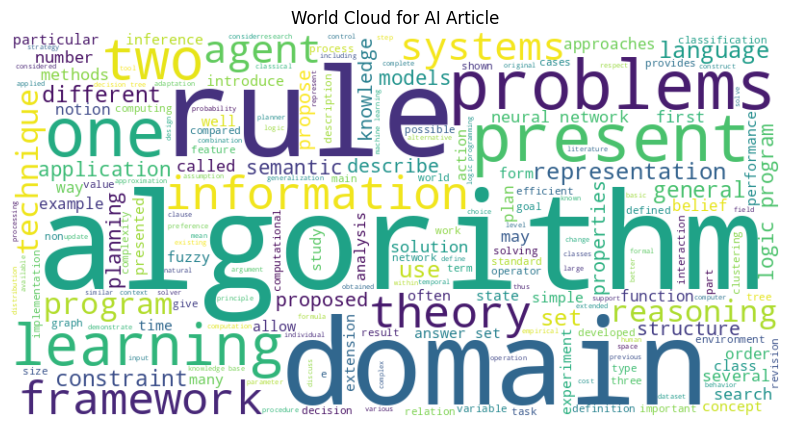

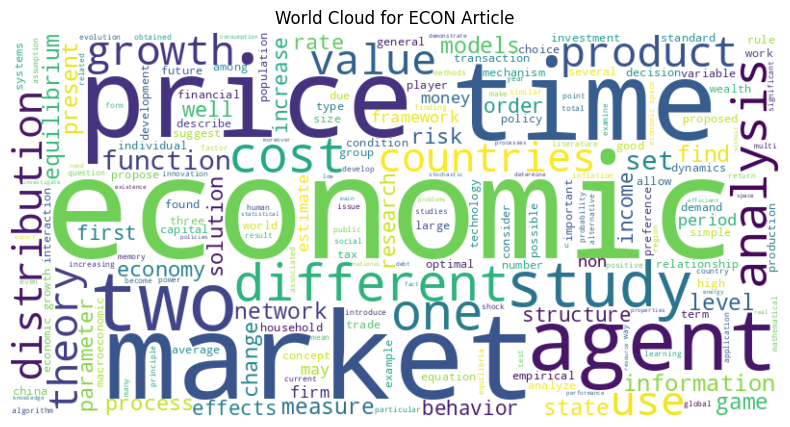

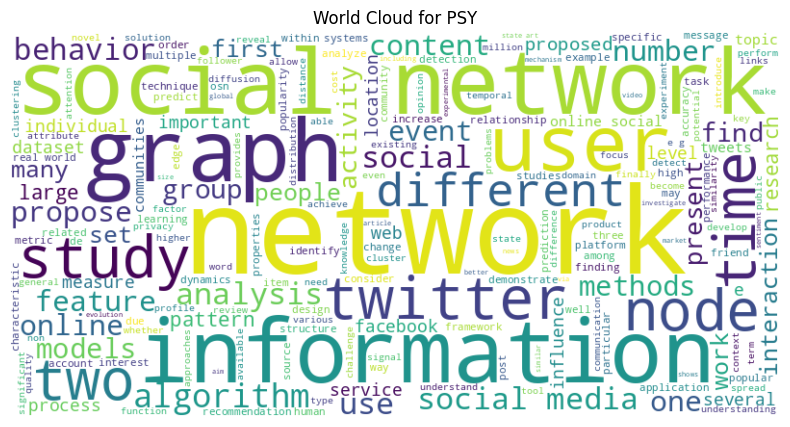

In [ ]:
# Redefine simplified_stop_words with the new provided list
simplified_stop_words = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours","We","the",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does",
    "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
    "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "scheduling", "approach", "data", "road", "used","The","impact","road", "authors", "leads", "grey","In","This","show","using","Use",
    'a','about','above','affect','after','again','against','all','am','an','and','any','approach','are','as','at','authors','be','because','been','before','being','below','between','both','but','by','can','case','constrain','data','did','do','does','doing','don','down','during','dynamic','each','effect','few','for','from','further','given','grey',
    'had','has','have','having','he','her','here','hers','herself','him','himself','his',
 'how','i','if','impact','in','into', 'is','it','its','itself','just','l','leads','link','me','more','most','my','myself','no','nor','not','now','obtain','of','off','on','once','only','or','other','our',
 'ours','ourselves','out','over','own','provide','road','s','same','scheduling','she','should','so','some','such','t','than','that','the','their','theirs', 'them','themselves','then','there','these',
 'they','this','those','through','to','too', 'tweet','under','until','up','used','very', 'was','we', 'were', 'what','when','where', 'which', 'while','who', 'whom', 'why','will','with','you','your','yours','yourself','yourselves'
,'model','based','users','paper','Our','new','results','also','problem','system','method'])

# Generate WordCloud excluding simplified_stop_words
def create_filtered_wordcloud(text, stop_words, title):
    # Tokenize and filter the text
    filtered_words = " ".join([word for word in re.findall(r'\w+', text.lower()) if word not in stop_words])
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(filtered_words)
    # Plot word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title)
    plt.show()


# Regenerate word clouds for each category excluding the updated simplified_stop_words
create_filtered_wordcloud(ai_summaries, simplified_stop_words, "World Cloud for AI Article")
create_filtered_wordcloud(econ_summaries, simplified_stop_words, "World Cloud for ECON Article")
create_filtered_wordcloud(psy_summaries, simplified_stop_words, "World Cloud for PSY")


Vocabulary size: 9194
DataLoader'lar hazırlandı.


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15 | Train Loss: 1.0993, Train Acc: 0.3659 | Val Loss: 1.0972, Val Acc: 0.3438
Epoch 2/15 | Train Loss: 1.0965, Train Acc: 0.3763 | Val Loss: 1.0941, Val Acc: 0.4062
Epoch 3/15 | Train Loss: 1.0884, Train Acc: 0.3971 | Val Loss: 1.0908, Val Acc: 0.3906
Epoch 4/15 | Train Loss: 1.0875, Train Acc: 0.3776 | Val Loss: 1.0896, Val Acc: 0.3802
Epoch 5/15 | Train Loss: 1.0783, Train Acc: 0.4049 | Val Loss: 1.0867, Val Acc: 0.3854
Epoch 6/15 | Train Loss: 1.0753, Train Acc: 0.4115 | Val Loss: 1.0813, Val Acc: 0.4062
Epoch 7/15 | Train Loss: 1.0638, Train Acc: 0.4583 | Val Loss: 1.0781, Val Acc: 0.4531
Epoch 8/15 | Train Loss: 1.0565, Train Acc: 0.4805 | Val Loss: 1.0748, Val Acc: 0.4115
Epoch 9/15 | Train Loss: 1.0539, Train Acc: 0.4766 | Val Loss: 1.0688, Val Acc: 0.4323
Epoch 10/15 | Train Loss: 1.0428, Train Acc: 0.5208 | Val Loss: 1.0646, Val Acc: 0.4531
Epoch 11/15 | Train Loss: 1.0310, Train Acc: 0.5286 | Val Loss: 1.0563, Val Acc: 0.5000
Epoch 12/15 | Train Loss: 1.0104, Train A

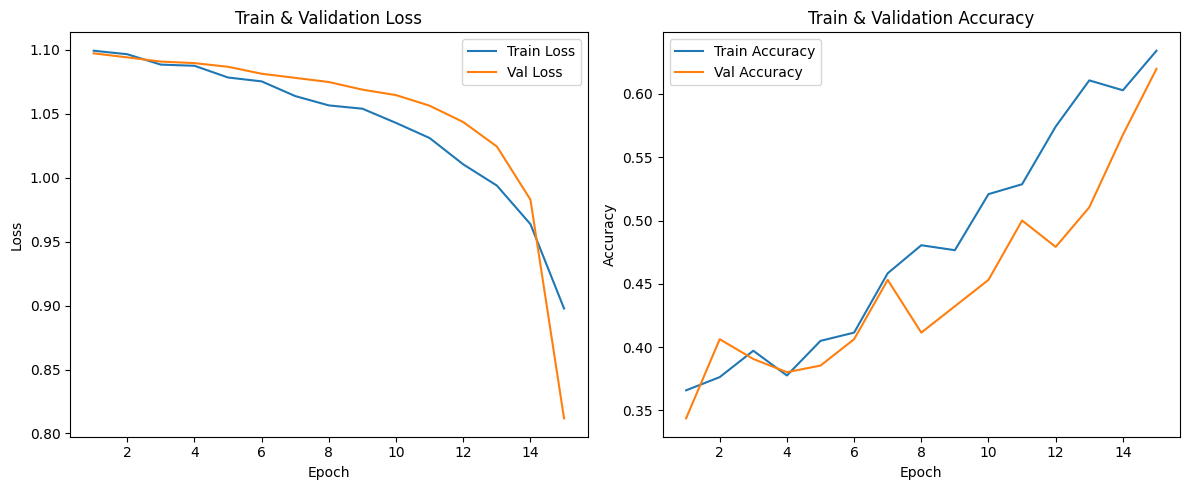

In [ ]:
###########################################
# 3. TOKENIZATION and Creating Vocab
############################################
import requests
import xml.etree.ElementTree as ET
import random
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import requests
import xml.etree.ElementTree as ET
import random
import re
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch.nn as nn
import torch.nn.functional as F
import re
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import requests
import xml.etree

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

############################################
# Simplified stop words
############################################
simplified_stop_words = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours","We","the",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does",
    "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
    "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "scheduling", "approach", "data", "road", "used","The","impact","road", "authors", "leads", "grey","In","This","show","using","Use",
    'a','about','above','affect','after','again','against','all','am','an','and','any','approach','are','as','at','authors','be','because','been','before','being','below','between','both','but','by','can','case','constrain','data','did','do','does','doing','don','down','during','dynamic','each','effect','few','for','from','further','given','grey',
    'had','has','have','having','he','her','here','hers','herself','him','himself','his',
    'how','i','if','impact','in','into', 'is','it','its','itself','just','l','leads','link','me','more','most','my','myself','no','nor','not','now','obtain','of','off','on','once','only','or','other','our',
    'ours','ourselves','out','over','own','provide','road','s','same','scheduling','she','should','so','some','such','t','than','that','the','their','theirs', 'them','themselves','then','there','these',
    'they','this','those','through','to','too', 'tweet','under','until','up','used','very', 'was','we', 'were', 'what','when','where', 'which', 'while','who', 'whom', 'why','will','with','you','your','yours','yourself','yourselves'
    ,'model','based','users','paper','Our','new','results','also','problem','system','method'
])

############################################
# 1) TOKENIZATION ve WORD2IDX
############################################

def tokenizer_with_simplified_stopwords(text, stopwords=simplified_stop_words, pattern=r"\b\w+\b"):
    """
    Tokenizes the text, converts to lowercase, removes stopwords, and extracts words using a regex pattern.
    """
    text = text.lower()
    tokens = re.findall(pattern, text)
    tokens = [t for t in tokens if t not in stopwords]
    return tokens


word_counts = Counter()
for txt in X_train_text:
    tokens = tokenizer_with_simplified_stopwords(txt)
    word_counts.update(tokens)

max_vocab_size = 10000
most_common_words = word_counts.most_common(max_vocab_size)

word2idx = {"<PAD>": 0, "<UNK>": 1}
idx = 2
for word, freq in most_common_words:
    word2idx[word] = idx
    idx += 1

vocab_size = len(word2idx)  # <= 10000 + 2
print("Vocabulary size:", vocab_size)


############################################
# 2) Vocab ID and Padding
############################################
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

sklearn_stopwords = set(ENGLISH_STOP_WORDS)

def tfidf_like_tokenizer(text, stopwords=sklearn_stopwords, pattern=r"\b\w+\b"):
    text = text.lower()
    tokens = re.findall(pattern, text)
    tokens = [t for t in tokens if t not in stopwords]
    return tokens

def convert_text_to_ids(text, word2idx):
    tokens = tfidf_like_tokenizer(text)
    ids = []
    for t in tokens:
        if t in word2idx:
            ids.append(word2idx[t])
        else:
            ids.append(word2idx["<UNK>"])
    return ids

def pad_sequences(sequences, max_len=200):
    padded = []
    for seq in sequences:
        if len(seq) < max_len:
            seq = seq + [word2idx["<PAD>"]] * (max_len - len(seq))
        else:
            seq = seq[:max_len]
        padded.append(seq)
    return padded

MAX_LEN = 200

X_train_ids = [convert_text_to_ids(txt, word2idx) for txt in X_train_text]
X_val_ids   = [convert_text_to_ids(txt, word2idx) for txt in X_val_text]
X_test_ids  = [convert_text_to_ids(txt, word2idx) for txt in X_test_text]

X_train_padded = pad_sequences(X_train_ids, MAX_LEN)
X_val_padded   = pad_sequences(X_val_ids, MAX_LEN)
X_test_padded  = pad_sequences(X_test_ids, MAX_LEN)

X_train_tensor = torch.LongTensor(X_train_padded)
y_train_tensor = torch.LongTensor(y_train)

X_val_tensor   = torch.LongTensor(X_val_padded)
y_val_tensor   = torch.LongTensor(y_val)

X_test_tensor  = torch.LongTensor(X_test_padded)
y_test_tensor  = torch.LongTensor(y_test)


############################################
# 3) DATASET & DATALOADER
############################################

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TextDataset(X_train_tensor, y_train_tensor)
val_dataset   = TextDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TextDataset(X_test_tensor,  y_test_tensor)

BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

print("DataLoader'lar hazırlandı.")


############################################
# 4) Model for LSTM and Evaulation Function
############################################

class LSTMEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 num_layers=1, bidirectional=False, dropout=0.0):
        super(LSTMEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout
        )
        self.directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (h_n, c_n) = self.lstm(embedded)

        if self.directions == 1:
            final_state = h_n[-1,:,:]  # (batch_size, hidden_dim)
        else:
            # bidirectional -> last layer forward = h_n[-2,:,:], backward = h_n[-1,:,:]
            forward_h = h_n[-2,:,:]
            backward_h = h_n[-1,:,:]
            final_state = torch.cat((forward_h, backward_h), dim=1)  # (batch_size, hidden_dim*2)
        return final_state

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=3, dropout=0.5):
        super(Classifier, self).__init__()

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        # Regularization with dropout
        x = self.dropout(x)
        logits = self.linear(x)
        return logits

def evaluate(encoder_model, clf_model, data_loader, criterion, device):
    encoder_model.eval()
    clf_model.eval()

    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            features = encoder_model(X_batch)
            logits = clf_model(features)
            loss = criterion(logits, y_batch)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == y_batch).sum().item()
            total_count   += len(y_batch)

    avg_loss = total_loss / len(data_loader)
    avg_acc  = total_correct / total_count
    return avg_loss, avg_acc


############################################
# 5)  TRAIN + VAL
############################################

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


embed_dim     = 128     # Embedding Dimension
hidden_dim    = 128
num_layers    = 1
bidirectional = True    # Two way
dropout_rate  = 0.5     # LSTM dropout
fc_dropout    = 0.5     # Classifier dropout

encoder_model = LSTMEncoder(
    vocab_size=vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    bidirectional=bidirectional,
    dropout=dropout_rate
).to(device)

clf_input_dim = hidden_dim * (2 if bidirectional else 1)
clf_model = Classifier(clf_input_dim, num_classes=3, dropout=fc_dropout).to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    list(encoder_model.parameters()) + list(clf_model.parameters()),
    lr=1e-4,
    weight_decay=1e-4
)

# ReduceLROnPlateau scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2,
    verbose=True
)

EPOCHS = 15

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

best_val_loss = float('inf')
early_stop_patience = 3
no_improvement_count = 0

best_encoder_state = None
best_clf_state = None

for epoch in range(EPOCHS):
    encoder_model.train()
    clf_model.train()

    running_loss = 0.0
    running_correct = 0
    running_count = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        features = encoder_model(X_batch)
        logits   = clf_model(features)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == y_batch).sum().item()
        running_count   += len(y_batch)

    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc  = running_correct / running_count

    # Validation
    val_epoch_loss, val_epoch_acc = evaluate(encoder_model, clf_model, val_loader, criterion, device)

    # LR Scheduler
    scheduler.step(val_epoch_loss)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accs.append(train_epoch_acc)
    val_accs.append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} | "
          f"Train Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.4f} | "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

    # Control for Early Stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        no_improvement_count = 0

        best_encoder_state = encoder_model.state_dict()
        best_clf_state = clf_model.state_dict()
    else:
        no_improvement_count += 1
        if no_improvement_count >= early_stop_patience:
            print("Early stopping triggered!")
            break

# Upload best model (after Early Stopping)
if best_encoder_state is not None and best_clf_state is not None:
    encoder_model.load_state_dict(best_encoder_state)
    clf_model.load_state_dict(best_clf_state)
    print("En iyi model ağırlıkları yüklendi.")

############################################
# 6) COntrol with Test Data SET
############################################

test_loss, test_acc = evaluate(encoder_model, clf_model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")


# 7) Graphs
############################################

epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs,   label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import classification_report, precision_recall_fscore_support

def compute_metrics(encoder_model, clf_model, data_loader, device):


    encoder_model.eval()
    clf_model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            features = encoder_model(X_batch)
            logits = clf_model(features)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())


    report = classification_report(
        all_labels,
        all_preds,
        digits=4
    )
    print("Classification Report:\n", report)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average='macro'
    )
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall:    {recall:.4f}")
    print(f"Macro F1-score:  {f1_score:.4f}")



# 1) Test Loss ve Acc
test_loss, test_acc = evaluate(encoder_model, clf_model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# 2) F1, Precision, Recall
compute_metrics(encoder_model, clf_model, test_loader, device)



Test Loss: 0.8608 | Test Acc: 0.6417
Classification Report:
               precision    recall  f1-score   support

           0     0.7143    0.5172    0.6000        87
           1     0.4737    0.6164    0.5357        73
           2     0.7805    0.8000    0.7901        80

    accuracy                         0.6417       240
   macro avg     0.6562    0.6446    0.6419       240
weighted avg     0.6632    0.6417    0.6438       240

Macro Precision: 0.6562
Macro Recall:    0.6446
Macro F1-score:  0.6419


<Figure size 800x800 with 0 Axes>

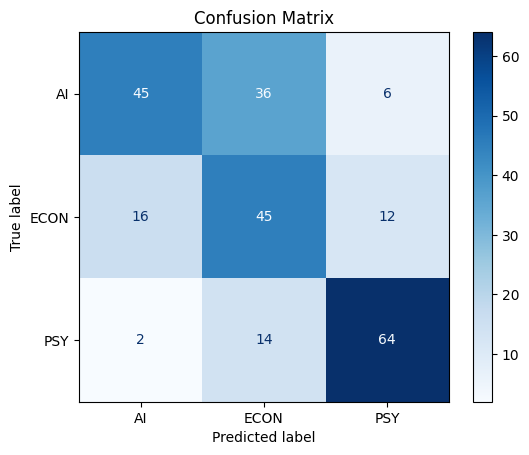

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def plot_confusion_matrix(encoder_model, clf_model, data_loader, device, class_names):
    """
    This function computes and plots the confusion matrix for the test dataset.

    Args:
        encoder_model (torch.nn.Module): The encoder model.
        clf_model (torch.nn.Module): The classifier model.
        data_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        device (torch.device): Device to perform computations on (e.g., 'cuda' or 'cpu').
        class_names (list): List of class names for display.
    """
    encoder_model.eval()
    clf_model.eval()

    all_preds = []
    all_labels = []


    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            features = encoder_model(X_batch)
            logits = clf_model(features)

            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

class_names = list(label2idx.keys())


plot_confusion_matrix(encoder_model, clf_model, test_loader, device, class_names)

Now, let's use the gloove embedding and change the LSTM model.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Veri tipi: <class 'list'>
Toplam veri: 1200
Örnek veri: ('Because of their occasional need to return to shallow points in a search\ntree, existing backtracking methods can sometimes erase meaningful progress\ntoward solving a search problem. In this paper, we present a method by which\nbacktrack points can be moved deeper in the search space, thereby avoiding this\ndifficulty. The technique developed is a variant of dependency-directed\nbacktracking that uses only polynomial space while still providing useful\ncontrol information and retaining the completeness guarantees provided by\nearlier approaches.', 'AI')
Veri boyutu (augment sonrası): (2400, 2)
GloVe embedding yükleniyor... Bu biraz zaman alabilir.
GloVe embedding yüklendi. Toplam kelime sayısı: 400000
Final Vocab Size: 4884
X_train_tensor shape: torch.Size([1680, 100])
y_train_tensor shape: torch.Size([1680])
Kullanılan cihaz: cuda
Epoch [1/10] Train Loss: 1.0095, Train Acc: 0.4821, Val Loss: 0.7455, Val Acc: 0.7722
Epoch [2/10

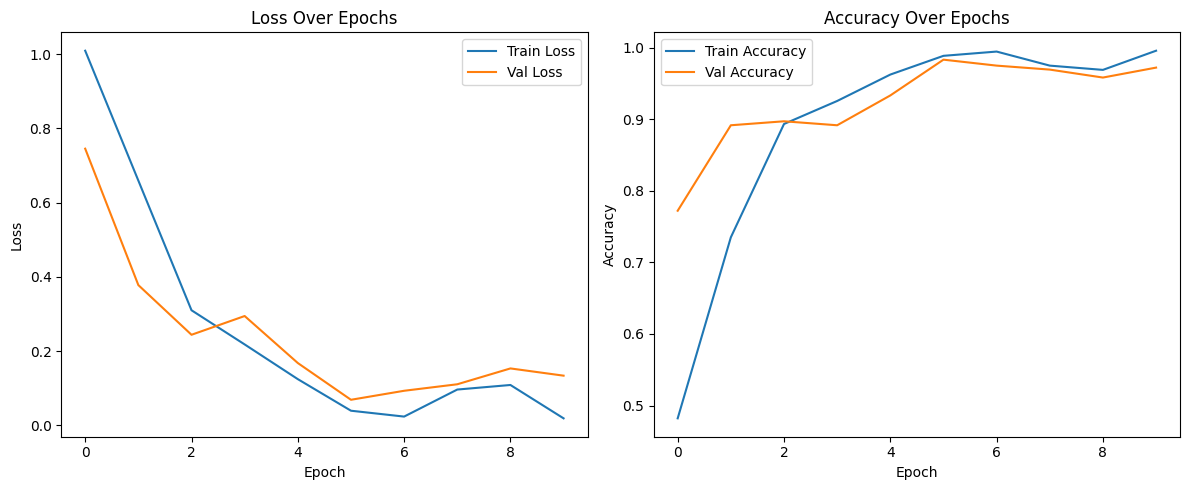

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from collections import Counter

###############################################################################
# 1) Again read same PKL file
###############################################################################
data = pd.read_pickle("/content/arxiv_data.pkl")

if isinstance(data, list):
    print(f"Toplam veri: {len(data)}")
    print("Örnek veri:", data[0])  # İlk elemanı ekrana bas
else:
    raise ValueError("PKL dosyası beklenmeyen bir formatta. DataFrame veya list olmalı.")

###############################################################################
# 2) LABEL ENCODING
###############################################################################
label2idx = {"AI": 0, "ECON": 1, "PSY": 2}

###############################################################################
# 3) DATA AUGMENTATION - Synonym Replacement
###############################################################################
stop_words = set(stopwords.words("english"))

def get_synonym(word):
    synsets = wordnet.synsets(word)
    if not synsets:
        return None
    # İlk synset içindeki lemma_names() -> [ "example_word", "synonym1", ... ]
    synonyms = [
        syn.lower().replace("_", " ")
        for syn in synsets[0].lemma_names()
        if syn.lower() != word.lower()
    ]
    return random.choice(synonyms) if synonyms else None

def augment_text_with_synonyms(text, n=2):
    words = text.split()
    if len(words) < 2:
        return text
    # only attention the words that not defined stop words
    content_word_indices = [
        i for i, w in enumerate(words)
        if w.lower() not in stop_words and re.match(r"^[a-zA-Z]+$", w)
    ]
    if len(content_word_indices) == 0:
        return text
    # choose random n number of word and replace them with synonyms
    random_indices = random.sample(content_word_indices, min(n, len(content_word_indices)))
    for idx in random_indices:
        synonym = get_synonym(words[idx])
        if synonym:
            words[idx] = synonym
    return " ".join(words)

# Original text + augment text
augmented_rows = []
for original_text, label in data:
    augmented_text = augment_text_with_synonyms(original_text, n=3)
    augmented_rows.append({"Summary": original_text, "Label": label})
    augmented_rows.append({"Summary": augmented_text, "Label": label})

# DataFrame
augmented_df = pd.DataFrame(augmented_rows)


# Change the label to 0, 1, 2
augmented_df["Label"] = augmented_df["Label"].map(label2idx)

###############################################################################
# 4) Tokenization and Cleaning
###############################################################################
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)
    return tokens

X = augmented_df["Summary"].tolist()
y = augmented_df["Label"].tolist()

# Train / Val / Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

###############################################################################
# 5) PRETRAINED GLOVE EMBEDDING
###############################################################################
glove_path = "/content/glove.6B.100d.txt"  # GloVe file path
embedding_dim = 100

word2vec_map = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
         word2vec_map[word] = vector


###############################################################################
# 6) WORD2IDX and PAD SEQUENCES
###############################################################################
counter = Counter()
for text in X_train:
    tokens = tokenize(text)
    counter.update(tokens)

max_vocab_size = 5000
most_common_words = counter.most_common(max_vocab_size)

word2idx = {"<PAD>": 0, "<UNK>": 1}
idx2word = {0: "<PAD>", 1: "<UNK>"}
idx = 2
for word, _ in most_common_words:
    # if it includes only glove, now add them
    if word in word2vec_map:
        word2idx[word] = idx
        idx2word[idx] = word
        idx += 1

vocab_size = len(word2idx)
print("Final Vocab Size:", vocab_size)

# Embedding matrix
embedding_matrix = np.random.normal(scale=0.05, size=(vocab_size, embedding_dim)).astype("float32")
for word, i in word2idx.items():
    if word in word2vec_map:
        embedding_matrix[i] = word2vec_map[word]

def text_to_ids(text):
    tokens = tokenize(text)
    ids = [word2idx.get(t, word2idx["<UNK>"]) for t in tokens]
    return ids

def pad_sequence_fn(seq, max_len=100):
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))
    return seq[:max_len]

def convert_and_pad(text_list, max_len=100):
    all_ids = [pad_sequence_fn(text_to_ids(txt), max_len) for txt in text_list]
    return torch.LongTensor(all_ids)

# Convert data into tensor
X_train_tensor = convert_and_pad(X_train)
X_val_tensor   = convert_and_pad(X_val)
X_test_tensor  = convert_and_pad(X_test)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor   = torch.LongTensor(y_val)
y_test_tensor  = torch.LongTensor(y_test)

print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)

###############################################################################
# 7) PYTORCH DATASET & DATALOADER
###############################################################################
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 4
train_dataset = TextDataset(X_train_tensor, y_train_tensor)
val_dataset   = TextDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TextDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

###############################################################################
# 8) LSTM MODEL + CLASSIFIER
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 num_layers=1, bidirectional=False, dropout=0.0, emb_matrix=None):
        super(LSTMEncoder, self).__init__()

        # Pretrained embedding
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if emb_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_matrix))

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (h_n, c_n) = self.lstm(embedded)
        if self.directions == 1:
            # if one way, one last hidden state will be enough
            final_state = h_n[-1, :, :]
        else:
            # two way => forward + backward last hidden state concat
            forward_h = h_n[-2, :, :]
            backward_h = h_n[-1, :, :]
            final_state = torch.cat((forward_h, backward_h), dim=1)
        return final_state

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=3, dropout=0.5):
        super(Classifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Hyperparameter
EMBED_DIM     = embedding_dim  # GloVe dimension (100)
HIDDEN_DIM    = 64
NUM_LAYERS    = 1
BIDIRECTIONAL = True
LSTM_DROPOUT  = 0.5r
FC_DROPOUT    = 0.5

encoder_model = LSTMEncoder(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=LSTM_DROPOUT,
    emb_matrix=embedding_matrix
).to(device)

clf_input_dim = HIDDEN_DIM * (2 if BIDIRECTIONAL else 1)
clf_model = Classifier(clf_input_dim, num_classes=3, dropout=FC_DROPOUT).to(device)

###############################################################################
# 9)  TRAIN + VALIDATION
###############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(encoder_model.parameters()) + list(clf_model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

def evaluate(encoder, classifier, data_loader, criterion, device):

    encoder.eval()
    classifier.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            feats = encoder(X_batch)
            logits = classifier(feats)
            loss = criterion(logits, y_batch)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == y_batch).sum().item()
            total_count += len(y_batch)

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / total_count
    return avg_loss, avg_acc

def compute_metrics(encoder_model, clf_model, data_loader, device):


    encoder_model.eval()
    clf_model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            features = encoder_model(X_batch)
            logits = clf_model(features)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Classification Report
    report = classification_report(
        all_labels,
        all_preds,
        digits=4,
        target_names=label2idx.keys()
    )
    print("Classification Report:\n", report)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average='macro'
    )
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall:    {recall:.4f}")
    print(f"Macro F1-score:  {f1_score:.4f}")


EPOCHS = 10
best_val_acc = 0.0

for epoch in range(EPOCHS):
    encoder_model.train()
    clf_model.train()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        feats = encoder_model(X_batch)
        logits = clf_model(feats)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == y_batch).sum().item()
        running_total += len(y_batch)

    train_loss = running_loss / len(train_loader)
    train_acc = running_correct / running_total

    # Validation set
    val_loss, val_acc = evaluate(encoder_model, clf_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Best Accuracy control
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_encoder_state = encoder_model.state_dict()
        best_clf_state = clf_model.state_dict()

# After training load best model.
encoder_model.load_state_dict(best_encoder_state)
clf_model.load_state_dict(best_clf_state)


###############################################################################
# 10) TEST Performance and Metrics
###############################################################################
test_loss, test_acc = evaluate(encoder_model, clf_model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# F1, Precision, Recall
compute_metrics(encoder_model, clf_model, test_loader, device)

###############################################################################
# 11) Graphs
###############################################################################
plt.figure(figsize=(12,5))

# Loss Graph
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


#Weight and Biases

In [ ]:
import wandb
import os


wandb.login()


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: ERROR API key must be 40 characters long, yours was 57


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
sweep_config = {
    "name": "LSTM_Sweep",
    "method": "bayes",  # grid, random, veya bayes
    "metric": {
      "name": "val_loss",
      "goal": "minimize"
    },
    "parameters": {
        "num_layers": {
            "values": [1, 2, 3]
        },
        "hidden_size": {
            "values": [64, 128, 256]
        },
        "dropout": {
            "values": [0.0, 0.2, 0.5]
        },
        "learning_rate": {
            "distribution": "log_uniform_values",
            "min": 1e-5,
            "max": 1e-3
        },
        "batch_size": {
            "values": [8, 16, 32]
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="my_lstm_project")


Create sweep with ID: 7k87amm3
Sweep URL: https://wandb.ai/merkan1114-middle-east-technical-university/my_lstm_project/sweeps/7k87amm3


In [ ]:
def create_lstm_models(vocab_size, emb_matrix, config):
    """
    config içinden parametreleri çekerek LSTMEncoder ve Classifier kurar.
    """
    hidden_dim = config.hidden_size
    num_layers = config.num_layers
    lstm_dropout = config.dropout
    fc_dropout = config.dropout

    # LSTM Encoder
    encoder_model = LSTMEncoder(
        vocab_size=vocab_size,
        embed_dim=embedding_dim,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        bidirectional=True,
        dropout=lstm_dropout,
        emb_matrix=emb_matrix
    ).to(device)

    # Classifier
    clf_input_dim = hidden_dim * 2  # bidirectional => 2x
    clf_model = Classifier(clf_input_dim, num_classes=3, dropout=fc_dropout).to(device)

    return encoder_model, clf_model
def get_optimizer(encoder_model, clf_model, config):
    # learning_rate, weight_decay  config
    optimizer = torch.optim.Adam(
        list(encoder_model.parameters()) + list(clf_model.parameters()),
        lr=config.learning_rate,
        weight_decay=1e-4
    )
    return optimizer


from collections import Counter
import torch


counts_dict = Counter(y_train)
counts_list = [counts_dict[i] for i in sorted(counts_dict.keys())]
class_weights = 1.0 / torch.tensor(counts_list, dtype=torch.float32)
class_weights = class_weights / class_weights.sum() * len(counts_list)
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)



In [ ]:
def run_sweep():
    with wandb.init() as run:
        config = wandb.config



        train_loader_sweep = DataLoader(
            train_dataset,
            batch_size=config.batch_size,
            shuffle=True,
            drop_last=False
        )
        val_loader_sweep = DataLoader(
            val_dataset,
            batch_size=config.batch_size,
            shuffle=False,
            drop_last=False
        )


        encoder_model, clf_model = create_lstm_models(vocab_size, embedding_matrix, config)

        #  Optimizer
        optimizer = get_optimizer(encoder_model, clf_model, config)


        best_val_acc = 0.0
        no_improve_count = 0
        patience = 3  #

        EPOCHS = 10  #
        for epoch in range(EPOCHS):
            # -- TRAIN STEP --
            encoder_model.train()
            clf_model.train()
            running_loss = 0.0
            running_correct = 0
            running_total = 0

            for X_batch, y_batch in train_loader_sweep:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                optimizer.zero_grad()
                feats = encoder_model(X_batch)
                logits = clf_model(feats)
                loss = criterion(logits, y_batch)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                preds = torch.argmax(logits, dim=1)
                running_correct += (preds == y_batch).sum().item()
                running_total += len(y_batch)

            train_loss = running_loss / len(train_loader_sweep)
            train_acc = running_correct / running_total

            # -- VAL STEP --
            val_loss, val_acc = evaluate(encoder_model, clf_model, val_loader_sweep, criterion, device)

            # -- wandb.log --
            wandb.log({
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
                "epoch": epoch+1
            })

            # Early stopping
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                no_improve_count = 0
            else:
                no_improve_count += 1
                if no_improve_count >= patience:
                    print(f"Early stopping triggered at epoch {epoch+1}.")
                    break

        print(f"Best Val Acc: {best_val_acc:.4f}")


In [ ]:
wandb.agent(sweep_id, function=run_sweep, count=20)

wandb: Agent Starting Run: c42apqxe with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	hidden_size: 128
wandb: 	learning_rate: 2.6994796286220073e-05
wandb: 	num_layers: 3
wandb: Currently logged in as: merkan1114 (merkan1114-middle-east-technical-university). Use `wandb login --relogin` to force relogin


Best Val Acc: 0.8306


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▁▁▂▃▄▅▇██
train_loss,█████▇▅▃▂▁
val_acc,▁▁▂▂▃▄▆▇██
val_loss,█████▇▄▃▂▁
epoch,10
train_acc,0.82619
train_loss,0.45906
val_acc,0.83056
val_loss,0.45311


wandb: Agent Starting Run: 7dgg3fn6 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0003160125265198242
wandb: 	num_layers: 3


Best Val Acc: 0.9389


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇▇████
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▅▆▇▇▇▇███
val_loss,█▄▃▂▂▂▂▁▁▁
epoch,10
train_acc,0.97321
train_loss,0.09497
val_acc,0.93889
val_loss,0.18306


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wyxtdltf with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.00014169050214727434
wandb: 	num_layers: 3


Best Val Acc: 0.8833


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▅▆▇▇█▇██
train_loss,█▇▅▃▃▂▂▂▁▁
val_acc,▁▃▅▆▇▇▆▇▇█
val_loss,█▆▄▄▂▂▄▁▂▁
epoch,10
train_acc,0.90357
train_loss,0.28678
val_acc,0.88333
val_loss,0.31825


wandb: Agent Starting Run: ehiiyzz1 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0001584828573499905
wandb: 	num_layers: 3


Best Val Acc: 0.8972


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▅▆▇▇▇▇██
train_loss,██▆▄▃▃▃▃▁▁
val_acc,▁▃▆▇▆█▅▇██
val_loss,██▄▃▄▂▆▂▁▁
epoch,10
train_acc,0.92202
train_loss,0.2372
val_acc,0.89722
val_loss,0.26776


wandb: Agent Starting Run: p3j0f4ul with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.0003663615685444563
wandb: 	num_layers: 1


Best Val Acc: 0.9306


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▅▆▆▆▇███
train_loss,█▅▄▃▃▃▂▂▁▁
val_acc,▁▆▆▇▇▇▇███
val_loss,█▄▄▃▂▂▂▁▁▁
epoch,10
train_acc,0.95119
train_loss,0.17023
val_acc,0.93056
val_loss,0.21961


wandb: Agent Starting Run: rd9i7fpr with config:
wandb: 	batch_size: 8
wandb: 	dropout: 0
wandb: 	hidden_size: 128
wandb: 	learning_rate: 3.141259528096583e-05
wandb: 	num_layers: 2


Best Val Acc: 0.8889


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▄▆▇▇████
train_loss,██▆▄▃▂▂▁▁▁
val_acc,▁▃▄▇▇█▇█▇█
val_loss,██▅▃▂▂▂▁▂▁
epoch,10
train_acc,0.89524
train_loss,0.32131
val_acc,0.88889
val_loss,0.32261


wandb: Agent Starting Run: n6jnjzss with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.00038632627855119046
wandb: 	num_layers: 2


Best Val Acc: 0.9250


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▇▇▇████
train_loss,█▇▄▃▃▂▁▁▂▁
val_acc,▁▅▇▇▇█▇███
val_loss,█▅▃▃▂▂▂▁▂▁
epoch,10
train_acc,0.95893
train_loss,0.14008
val_acc,0.925
val_loss,0.22491


wandb: Agent Starting Run: 518z72wg with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0006288227735644548
wandb: 	num_layers: 3


Best Val Acc: 0.9611


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▅▆▇▇██▇██
train_loss,█▅▃▃▂▂▂▂▁▁
val_acc,▁▇▇▇██▇███
val_loss,█▃▃▂▂▁▂▂▁▁
epoch,10
train_acc,0.98452
train_loss,0.05535
val_acc,0.96111
val_loss,0.15378


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: b49sfrpt with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0009721124012088882
wandb: 	num_layers: 3


Early stopping triggered at epoch 9.
Best Val Acc: 0.9417


epoch,▁▂▃▄▅▅▆▇█
train_acc,▁▄▅▇▇████
train_loss,█▆▄▃▂▁▁▁▁
val_acc,▁▁▃▇██▆▇█
val_loss,██▇▂▂▁▂▂▂
epoch,9
train_acc,0.97619
train_loss,0.09019
val_acc,0.93611
val_loss,0.21289


wandb: Agent Starting Run: pkwd1rh0 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0009578039686304468
wandb: 	num_layers: 3


Best Val Acc: 0.9528


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇█████
train_loss,█▆▄▃▂▂▂▁▁▁
val_acc,▁▃▆▆▇█████
val_loss,█▆▄▃▂▂▂▂▁▁
epoch,10
train_acc,0.9875
train_loss,0.04098
val_acc,0.95
val_loss,0.18845


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 00p42b5k with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0006669344202106836
wandb: 	num_layers: 3


Early stopping triggered at epoch 7.
Best Val Acc: 0.9306


epoch,▁▂▃▅▆▇█
train_acc,▁▅▇▇███
train_loss,█▄▃▂▁▁▁
val_acc,▁▄▇██▇█
val_loss,█▅▃▁▁▂▁
epoch,7
train_acc,0.96726
train_loss,0.11773
val_acc,0.92778
val_loss,0.23197


wandb: Agent Starting Run: qsvpfue9 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	hidden_size: 128
wandb: 	learning_rate: 0.00028590195168823665
wandb: 	num_layers: 1


Best Val Acc: 0.9139


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▃▆▆▇▇▇███
train_loss,█▆▄▃▃▂▂▁▁▁
val_acc,▁▅▄▇▇█████
val_loss,█▅▅▃▂▂▂▁▂▁
epoch,10
train_acc,0.95
train_loss,0.16249
val_acc,0.91389
val_loss,0.23319


wandb: Agent Starting Run: r8gioqsu with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	hidden_size: 128
wandb: 	learning_rate: 1.9108106728754534e-05
wandb: 	num_layers: 2


Early stopping triggered at epoch 6.
Best Val Acc: 0.4556


epoch,▁▂▄▅▇█
train_acc,▁▄▄▆██
train_loss,█▆▅▄▂▁
val_acc,▁▇█▅▄▅
val_loss,█▇▆▄▃▁
epoch,6
train_acc,0.4494
train_loss,1.08692
val_acc,0.41667
val_loss,1.08828


wandb: Agent Starting Run: wkjhtf8e with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 4.600667357518694e-05
wandb: 	num_layers: 1


Best Val Acc: 0.8194


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▃▃▄▅▇███
train_loss,███▇▇▅▄▂▁▁
val_acc,▁▂▂▃▅▅▇███
val_loss,████▆▅▃▂▂▁
epoch,10
train_acc,0.82798
train_loss,0.47933
val_acc,0.81944
val_loss,0.4474


wandb: Agent Starting Run: 1849kcka with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	hidden_size: 64
wandb: 	learning_rate: 1.940939650846509e-05
wandb: 	num_layers: 3


Early stopping triggered at epoch 4.
Best Val Acc: 0.3333


epoch,▁▃▆█
train_acc,▁▁▁▁
train_loss,█▅▃▁
val_acc,▁▁▁▁
val_loss,█▅▃▁
epoch,4
train_acc,0.3369
train_loss,1.09581
val_acc,0.33333
val_loss,1.09373


wandb: Agent Starting Run: jtjxbtqt with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	hidden_size: 64
wandb: 	learning_rate: 0.0004729176275511288
wandb: 	num_layers: 2


Best Val Acc: 0.9333


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▄▆▇▇█████
train_loss,█▆▃▃▂▂▁▁▁▁
val_acc,▁▆▇▅█▇███▇
val_loss,█▄▃▄▂▂▁▁▁▃
epoch,10
train_acc,0.9625
train_loss,0.12593
val_acc,0.85
val_loss,0.39316


wandb: Agent Starting Run: puwk9c28 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	hidden_size: 64
wandb: 	learning_rate: 2.61138141176247e-05
wandb: 	num_layers: 2


Best Val Acc: 0.6139


epoch,▁▂▃▃▄▅▆▆▇█
train_acc,▁▂▂▃▄▅▆▆▇█
train_loss,███▇▇▇▆▆▄▁
val_acc,▁▃▄▄▄▅▅▅▆█
val_loss,████▇▇▇▆▅▁
epoch,10
train_acc,0.5625
train_loss,1.02162
val_acc,0.61389
val_loss,0.98837


wandb: Agent Starting Run: zjvzwcvq with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.5
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.0003308690531577243
wandb: 	num_layers: 1


Early stopping triggered at epoch 6.
Best Val Acc: 0.8389


epoch,▁▂▄▅▇█
train_acc,▁▅██▇▇
train_loss,█▄▁▁▂▂
val_acc,▁▆█▃▁▅
val_loss,█▄▁▅▆▄
epoch,6
train_acc,0.74048
train_loss,0.59763
val_acc,0.71944
val_loss,0.59606


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: s7u72qdd with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	hidden_size: 256
wandb: 	learning_rate: 0.00013231741879860196
wandb: 	num_layers: 3


<Figure size 800x800 with 0 Axes>

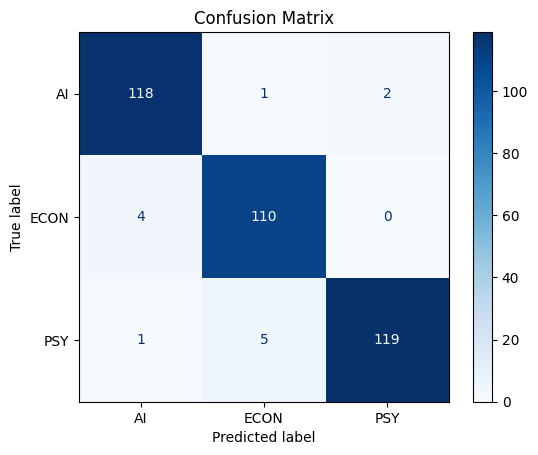

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(encoder_model, clf_model, data_loader, device, class_names):

    encoder_model.eval()
    clf_model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            features = encoder_model(X_batch)
            logits = clf_model(features)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

class_names = list(label2idx.keys())
plot_confusion_matrix(encoder_model, clf_model, test_loader, device, class_names)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Toplam veri: 1200
Örnek veri: ('Because of their occasional need to return to shallow points in a search\ntree, existing backtracking methods can sometimes erase meaningful progress\ntoward solving a search problem. In this paper, we present a method by which\nbacktrack points can be moved deeper in the search space, thereby avoiding this\ndifficulty. The technique developed is a variant of dependency-directed\nbacktracking that uses only polynomial space while still providing useful\ncontrol information and retaining the completeness guarantees provided by\nearlier approaches.', 'AI')
Final Vocab Size: 4881
X_train_tensor shape: torch.Size([1680, 100])
y_train_tensor shape: torch.Size([1680])
Epoch [1/10] Train Loss: 0.9203, Train Acc: 0.5536, Val Loss: 0.4998, Val Acc: 0.7917
Epoch [2/10] Train Loss: 0.3691, Train Acc: 0.8720, Val Loss: 0.2687, Val Acc: 0.8972
Epoch [3/10] Train Loss: 0.1322, Train Acc: 0.9595, Val Loss: 0.0802, Val Acc: 0.9778
Epoch [4/10] Train Loss: 0.0606, Train 

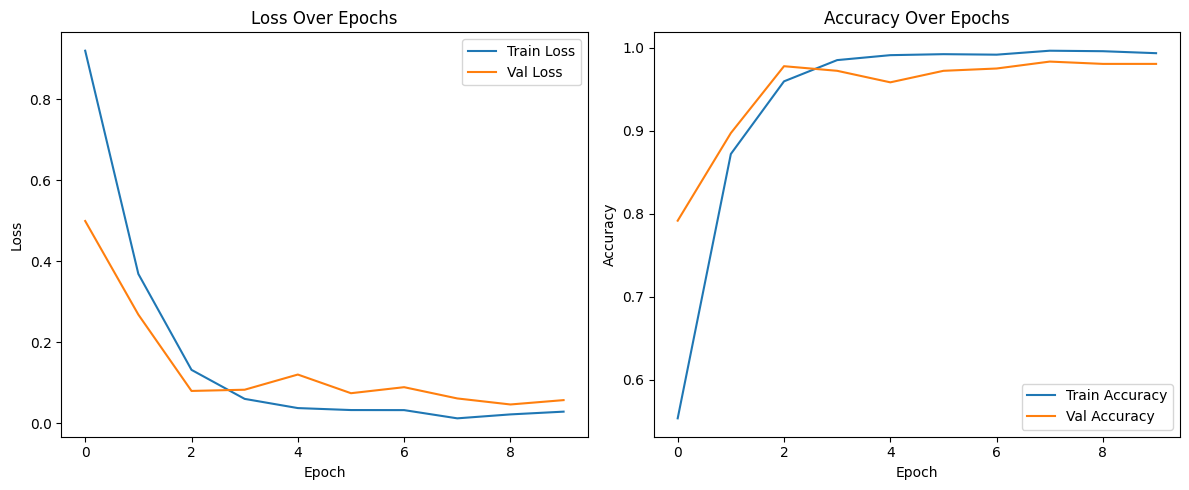

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from collections import Counter

###############################################################################
# 1) Read Dataset
###############################################################################
data = pd.read_pickle("/content/arxiv_data.pkl")

if isinstance(data, list):
    print(f"Toplam veri: {len(data)}")
    print("Örnek veri:", data[0])
else:
    raise ValueError("PKL dosyası beklenmeyen bir formatta. DataFrame veya list olmalı.")

###############################################################################
# 2) LABEL ENCODING
###############################################################################
label2idx = {"AI": 0, "ECON": 1, "PSY": 2}

###############################################################################
# 3) DATA AUGMENTATION - Synonym Replacement
###############################################################################
stop_words = set(stopwords.words("english"))

def get_synonym(word):
    synsets = wordnet.synsets(word)
    if not synsets:
        return None
    synonyms = [
        syn.lower().replace("_", " ")
        for syn in synsets[0].lemma_names()
        if syn.lower() != word.lower()
    ]
    return random.choice(synonyms) if synonyms else None

def augment_text_with_synonyms(text, n=2):
    words = text.split()
    if len(words) < 2:
        return text
    content_word_indices = [
        i for i, w in enumerate(words)
        if w.lower() not in stop_words and re.match(r"^[a-zA-Z]+$", w)
    ]
    if len(content_word_indices) == 0:
        return text
    random_indices = random.sample(content_word_indices, min(n, len(content_word_indices)))
    for idx in random_indices:
        synonym = get_synonym(words[idx])
        if synonym:
            words[idx] = synonym
    return " ".join(words)

# Original data + Augment data
augmented_rows = []
for original_text, label in data:
    augmented_text = augment_text_with_synonyms(original_text, n=3)
    augmented_rows.append({"Summary": original_text, "Label": label})
    augmented_rows.append({"Summary": augmented_text, "Label": label})

# DataFrame
augmented_df = pd.DataFrame(augmented_rows)

# Label 0,1,2
augmented_df["Label"] = augmented_df["Label"].map(label2idx)

###############################################################################
# 4) Tokenization and Cleaning
###############################################################################
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)
    return tokens

X = augmented_df["Summary"].tolist()
y = augmented_df["Label"].tolist()

# Train / Val / Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

###############################################################################
# 5) PRETRAINED GLOVE EMBEDDING
###############################################################################
glove_path = "/content/glove.6B.100d.txt"  # GloVe path
embedding_dim = 100

word2vec_map = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        word2vec_map[word] = vector

###############################################################################
# 6) WORD2IDX and PAD SEQUENCES
###############################################################################
counter = Counter()
for text in X_train:
    tokens = tokenize(text)
    counter.update(tokens)

max_vocab_size = 5000
most_common_words = counter.most_common(max_vocab_size)

word2idx = {"<PAD>": 0, "<UNK>": 1}
idx2word = {0: "<PAD>", 1: "<UNK>"}
idx = 2
for word, _ in most_common_words:

    if word in word2vec_map:
        word2idx[word] = idx
        idx2word[idx] = word
        idx += 1

vocab_size = len(word2idx)
print("Final Vocab Size:", vocab_size)

# Embedding matrix
embedding_matrix = np.random.normal(scale=0.05, size=(vocab_size, embedding_dim)).astype("float32")
for word, i in word2idx.items():
    if word in word2vec_map:
        embedding_matrix[i] = word2vec_map[word]

def text_to_ids(text):
    tokens = tokenize(text)
    ids = [word2idx.get(t, word2idx["<UNK>"]) for t in tokens]
    return ids

def pad_sequence_fn(seq, max_len=100):
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))
    return seq[:max_len]

def convert_and_pad(text_list, max_len=100):
    all_ids = [pad_sequence_fn(text_to_ids(txt), max_len) for txt in text_list]
    return torch.LongTensor(all_ids)

# Tensor
X_train_tensor = convert_and_pad(X_train)
X_val_tensor   = convert_and_pad(X_val)
X_test_tensor  = convert_and_pad(X_test)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor   = torch.LongTensor(y_val)
y_test_tensor  = torch.LongTensor(y_test)

print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)

###############################################################################
# 7) PYTORCH DATASET & DATALOADER
###############################################################################
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 4
train_dataset = TextDataset(X_train_tensor, y_train_tensor)
val_dataset   = TextDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TextDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

###############################################################################
# 8) GRU MODEL + CLASSIFIER
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GRUEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 num_layers=1, bidirectional=False, dropout=0.0, emb_matrix=None):
        super(GRUEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)


        if emb_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_matrix))

        # GRU
        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        outputs, h_n = self.gru(embedded)
        # h_n: [num_layers * directions, batch_size, hidden_size]

        if self.directions == 1:

            final_state = h_n[-1, :, :]
        else:

            forward_h = h_n[-2, :, :]
            backward_h = h_n[-1, :, :]
            final_state = torch.cat((forward_h, backward_h), dim=1)

        return final_state

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=3, dropout=0.5):
        super(Classifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Hyperparamaters
EMBED_DIM     = embedding_dim  # GloVe dimension (100)
HIDDEN_DIM    = 64
NUM_LAYERS    = 1
BIDIRECTIONAL = True
GRU_DROPOUT   = 0.5
FC_DROPOUT    = 0.5

encoder_model = GRUEncoder(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=GRU_DROPOUT,
    emb_matrix=embedding_matrix
).to(device)

clf_input_dim = HIDDEN_DIM * (2 if BIDIRECTIONAL else 1)
clf_model = Classifier(clf_input_dim, num_classes=3, dropout=FC_DROPOUT).to(device)

###############################################################################
# 9)  TRAIN + VALIDATION
###############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(encoder_model.parameters()) + list(clf_model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

def evaluate(encoder, classifier, data_loader, criterion, device):
    encoder.eval()
    classifier.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            feats = encoder(X_batch)
            logits = classifier(feats)
            loss = criterion(logits, y_batch)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == y_batch).sum().item()
            total_count += len(y_batch)

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / total_count
    return avg_loss, avg_acc

def compute_metrics(encoder_model, clf_model, data_loader, device):
    encoder_model.eval()
    clf_model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            features = encoder_model(X_batch)
            logits = clf_model(features)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Classification Report
    report = classification_report(
        all_labels,
        all_preds,
        digits=4,
        target_names=label2idx.keys()
    )
    print("Classification Report:\n", report)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average='macro'
    )
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall:    {recall:.4f}")
    print(f"Macro F1-score:  {f1_score:.4f}")


EPOCHS = 10
best_val_acc = 0.0

for epoch in range(EPOCHS):
    encoder_model.train()
    clf_model.train()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        feats = encoder_model(X_batch)
        logits = clf_model(feats)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == y_batch).sum().item()
        running_total += len(y_batch)

    train_loss = running_loss / len(train_loader)
    train_acc = running_correct / running_total

    # Validation set
    val_loss, val_acc = evaluate(encoder_model, clf_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Check the best accuracy and validation
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_encoder_state = encoder_model.state_dict()
        best_clf_state = clf_model.state_dict()

# Load Best Model
encoder_model.load_state_dict(best_encoder_state)
clf_model.load_state_dict(best_clf_state)


###############################################################################
# 10) TEST Performance and Metrics
###############################################################################
test_loss, test_acc = evaluate(encoder_model, clf_model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# F1, Precision, Recall
compute_metrics(encoder_model, clf_model, test_loader, device)

###############################################################################
# 11) Graphs
###############################################################################
plt.figure(figsize=(12,5))

# Loss Graph
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy Graph
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


<Figure size 800x800 with 0 Axes>

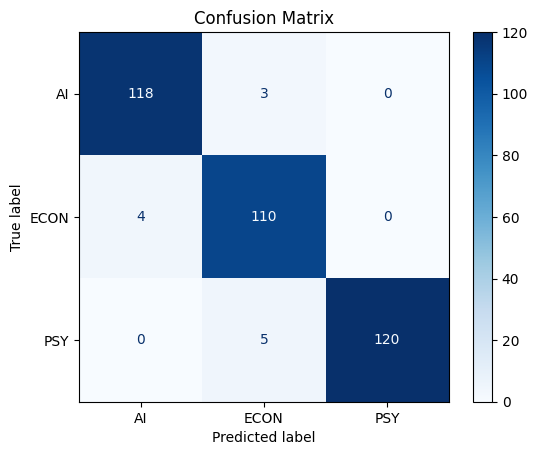

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(encoder_model, clf_model, data_loader, device, class_names):

    encoder_model.eval()
    clf_model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            features = encoder_model(X_batch)
            logits = clf_model(features)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

class_names = list(label2idx.keys())
plot_confusion_matrix(encoder_model, clf_model, test_loader, device, class_names)

#BERT

Train set: 768
Val set  : 192
Test set : 240


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Kullanılan cihaz: cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4
  Train loss: 0.9167, Train acc: 0.5768
  Val   loss: 0.5260,   Val acc:   0.8698
Epoch 2/4
  Train loss: 0.3478, Train acc: 0.9049
  Val   loss: 0.2245,   Val acc:   0.9375
Epoch 3/4
  Train loss: 0.1767, Train acc: 0.9544
  Val   loss: 0.1517,   Val acc:   0.9583
Epoch 4/4
  Train loss: 0.0893, Train acc: 0.9779
  Val   loss: 0.2271,   Val acc:   0.9271

Test Loss: 0.1832, Test Acc: 0.9500
Confusion Matrix:
 [[86  1  0]
 [ 7 65  1]
 [ 1  2 77]]


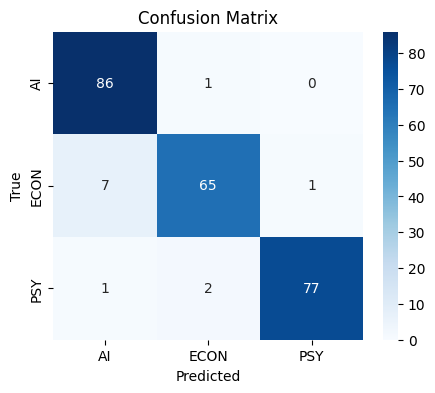

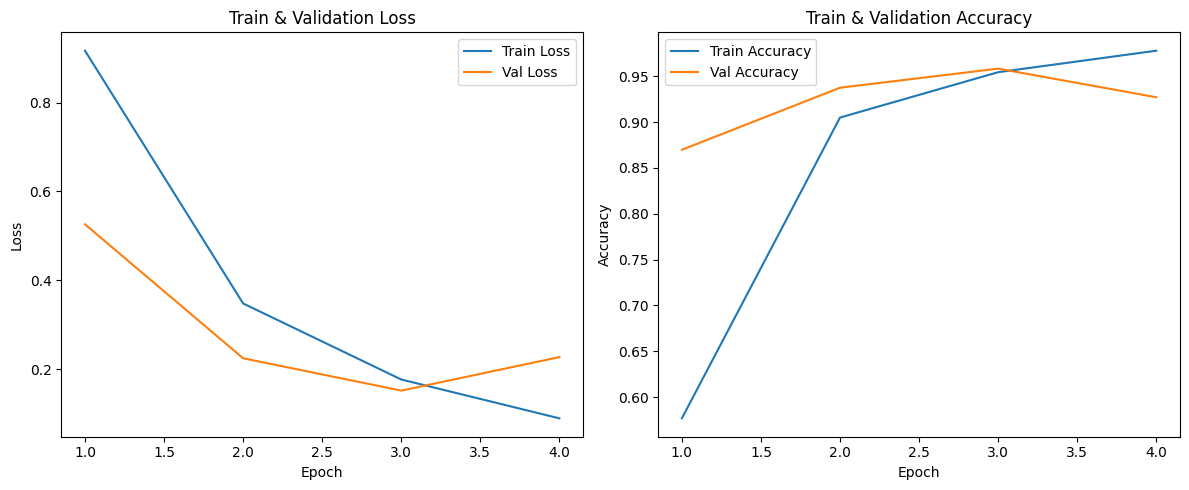

In [ ]:
############################################
# 0. Libraries
############################################


import requests
import xml.etree.ElementTree as ET
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizer, BertForSequenceClassification, AdamW

import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


############################################
# 2. Labelling
#    (TRAIN - VAL - TEST)
############################################

label2idx = {"AI": 0, "ECON": 1, "PSY": 2}

X = [text for (text, lbl) in data]
y = [label2idx[lbl] for (text, lbl) in data]


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42
)

print("Train set:", len(X_train))
print("Val set  :", len(X_val))
print("Test set :", len(X_test))

############################################
# 3. BERT TOKENIZER ve DATASET
############################################

PRETRAINED_MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

MAX_LEN = 128

class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",  # pad for max_len
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Dataset & DataLoader
train_dataset = BertDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset   = BertDataset(X_val,   y_val,   tokenizer, MAX_LEN)
test_dataset  = BertDataset(X_test,  y_test,  tokenizer, MAX_LEN)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)


############################################
# 4. BERT Modelling
############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NUM_LABELS = 3
model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME,
    num_labels=NUM_LABELS
).to(device)

# BERT optimizer: AdamW
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
# CrossEntropyLoss actually comes automatically from within the model,
# but we will get logits and loss with "outputs.loss".

EPOCHS = 4

############################################
# 5. Training and Evaulation Function
############################################

def train_epoch(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Clean for the Gradientleri
        optimizer.zero_grad()

        # BertForSequenceClassification -> (loss, logits)
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total   += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total   += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

############################################
# 6. Main Training Part
############################################

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f},   Val acc:   {val_acc:.4f}")

############################################
# 7. Control on Test Set after Training
############################################

test_loss, test_acc = eval_epoch(model, test_loader, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

############################################
# 8. CONFUSION MATRIX & Graphs
############################################

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# confusion matrix
cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
print("Confusion Matrix:\n", cm)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["AI","ECON","PSY"],
            yticklabels=["AI","ECON","PSY"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

############################################

############################################

epochs_range = range(1, EPOCHS+1)
plt.figure(figsize=(12, 5))

# Loss Graph
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses,   label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()

# Accuracy Graph
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs,   label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


Let's change the hyperparameter and developed our Bert model

Train set: 768
Val set  : 192
Test set : 240
Kullanılan cihaz: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/4
  Train loss: 0.8144, Train acc: 0.6927
  Val   loss: 0.3786,   Val acc:   0.9219
Epoch 2/4
  Train loss: 0.3016, Train acc: 0.9232
  Val   loss: 0.1834,   Val acc:   0.9583
Epoch 3/4
  Train loss: 0.1634, Train acc: 0.9609
  Val   loss: 0.1483,   Val acc:   0.9688
Epoch 4/4
  Train loss: 0.1005, Train acc: 0.9857
  Val   loss: 0.1491,   Val acc:   0.9635

Test Loss: 0.1646, Test Acc: 0.9583
Confusion Matrix:
 [[83  3  1]
 [ 2 70  1]
 [ 1  2 77]]

Classification Report:

              precision    recall  f1-score   support

          AI       0.97      0.95      0.96        87
        ECON       0.93      0.96      0.95        73
         PSY       0.97      0.96      0.97        80

    accuracy                           0.96       240
   macro avg       0.96      0.96      0.96       240
weighted avg       0.96      0.96      0.96       240



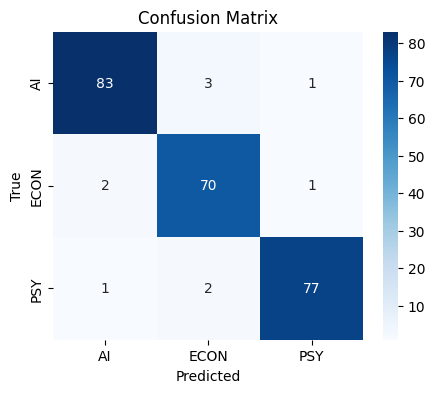

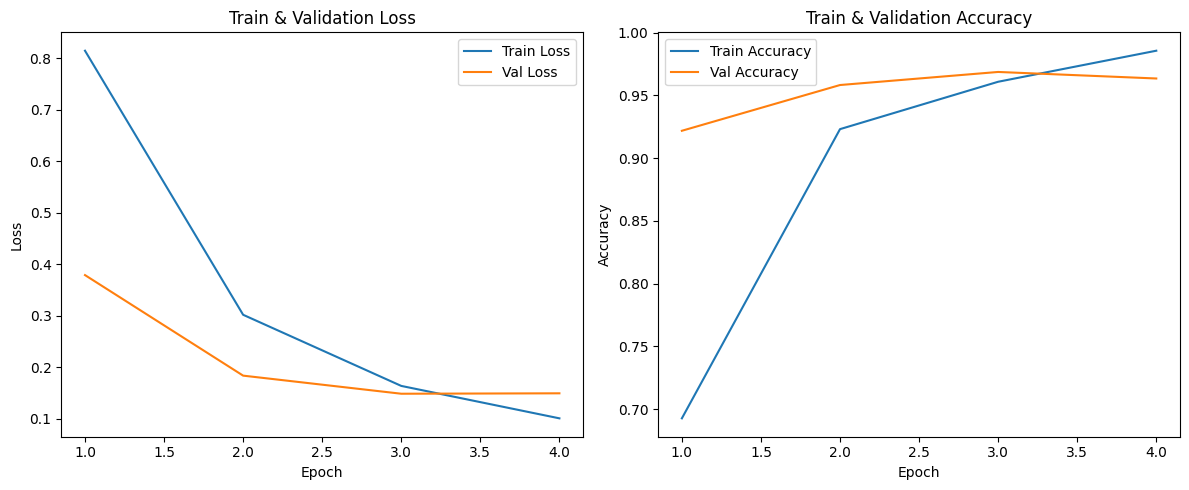

In [ ]:

label2idx = {"AI": 0, "ECON": 1, "PSY": 2}

X = [text for (text, lbl) in data]
y = [label2idx[lbl] for (text, lbl) in data]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Train set:", len(X_train))
print("Val set  :", len(X_val))
print("Test set :", len(X_test))

PRETRAINED_MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

MAX_LEN = 128

class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

# Dataset & DataLoader
train_dataset = BertDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset   = BertDataset(X_val,   y_val,   tokenizer, MAX_LEN)
test_dataset  = BertDataset(X_test,  y_test,  tokenizer, MAX_LEN)

BATCH_SIZE = 16

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

############################################
# 4. Prepare BERT Modelling
############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


NUM_LABELS = 3
model = BertForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME,
    num_labels=NUM_LABELS
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = EPOCHS * len(train_loader)
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

############################################
# 5. Training and Evaluation Function
############################################

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total   += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total   += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

############################################
# 6. Main Training Part
############################################

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, lr_scheduler, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f},   Val acc:   {val_acc:.4f}")

############################################
# 7. Control on TEST SET
############################################

test_loss, test_acc = eval_epoch(model, test_loader, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

############################################
# 8. CONFUSION MATRIX and Classification Report
############################################

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["AI", "ECON", "PSY"]))

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["AI", "ECON", "PSY"],
            yticklabels=["AI", "ECON", "PSY"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

############################################
# 9. Training Graphs
############################################

epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import os
import wandb
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
    get_scheduler
)

wandb.login()


True

In [ ]:


label2idx = {"AI": 0, "ECON": 1, "PSY": 2}


X = [text for (text, lbl) in data]
y = [label2idx[lbl] for (text, lbl) in data]

# Train/Val/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val,  y_train, y_val  = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Train set:", len(X_train))
print("Val set  :", len(X_val))
print("Test set :", len(X_test))


Train set: 768
Val set  : 192
Test set : 240


In [ ]:
PRETRAINED_MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
MAX_LEN = 128

class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text  = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

def create_data_loader(X, y, tokenizer, batch_size, max_len=128, shuffle=False):
    ds = BertDataset(X, y, tokenizer, max_len)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)



In [ ]:
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total   += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total   += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


In [ ]:
sweep_config = {
    "method": "bayes",
    "metric": {
      "name": "val_acc",
      "goal": "maximize"
    },
    "parameters": {
        "epochs": {
            "values": [3, 4, 5]
        },
        "learning_rate": {
            "distribution": "log_uniform_values",
            "min": 1e-5,
            "max": 1e-4
        },
        "batch_size": {
            "values": [8, 16, 32]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, project="bert_sweep_demo")


Create sweep with ID: smcbyq7o
Sweep URL: https://wandb.ai/merkan1114-middle-east-technical-university/bert_sweep_demo/sweeps/smcbyq7o


In [ ]:
def run_sweep():
    with wandb.init() as run:
        config = wandb.config


        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = BertForSequenceClassification.from_pretrained(
            PRETRAINED_MODEL_NAME,
            num_labels=3
        ).to(device)


        train_loader = create_data_loader(
            X_train, y_train,
            tokenizer,
            batch_size=config.batch_size,  # Sweep
            max_len=MAX_LEN,
            shuffle=True
        )
        val_loader = create_data_loader(
            X_val, y_val,
            tokenizer,
            batch_size=config.batch_size,
            max_len=MAX_LEN,
            shuffle=False
        )

        #  Optimizer ve Scheduler
        optimizer = AdamW(model.parameters(), lr=config.learning_rate, weight_decay=0.01)
        num_training_steps = config.epochs * len(train_loader)
        lr_scheduler = get_scheduler("linear", optimizer=optimizer,
                                     num_warmup_steps=0,
                                     num_training_steps=num_training_steps)

        best_val_acc = 0.0
        for epoch in range(config.epochs):
            train_loss, train_acc = train_epoch(model, train_loader, optimizer, lr_scheduler, device)
            val_loss, val_acc = eval_epoch(model, val_loader, device)

            # wandb.log
            wandb.log({
                "epoch": epoch+1,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc
            })

            if val_acc > best_val_acc:
                best_val_acc = val_acc

        # Best Model Result:
        print(f"Best Val Acc: {best_val_acc:.4f}")
        wandb.log({"best_val_acc": best_val_acc})


In [ ]:
wandb.agent(sweep_id, function=run_sweep, count=10)


wandb: Agent Starting Run: ki4b87c3 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	learning_rate: 8.248018487383632e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Best Val Acc: 0.9010


best_val_acc,▁
epoch,▁▅█
train_acc,▁▇█
train_loss,█▂▁
val_acc,▁▃█
val_loss,█▇▁
best_val_acc,0.90104
epoch,3
train_acc,0.98438
train_loss,0.06591
val_acc,0.90104


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9jm6lvcd with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	learning_rate: 2.888463418099258e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best Val Acc: 0.9062


best_val_acc,▁
epoch,▁▅█
train_acc,▁▇█
train_loss,█▂▁
val_acc,▁██
val_loss,█▁▂
best_val_acc,0.90625
epoch,3
train_acc,0.98047
train_loss,0.06549
val_acc,0.90625


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a6hyqq9o with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	learning_rate: 2.4067844045607744e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best Val Acc: 0.8802


best_val_acc,▁
epoch,▁▅█
train_acc,▁▆█
train_loss,█▃▁
val_acc,▁██
val_loss,█▂▁
best_val_acc,0.88021
epoch,3
train_acc,0.97396
train_loss,0.10223
val_acc,0.88021


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 84jmjjui with config:
wandb: 	batch_size: 8
wandb: 	epochs: 5
wandb: 	learning_rate: 1.0327863062667574e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best Val Acc: 0.9010


wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


best_val_acc,▁
epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,█▄▁█▁
val_loss,█▂▁▂▃
best_val_acc,0.90104
epoch,5
train_acc,0.99479
train_loss,0.05419
val_acc,0.89062


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l6o5xfk6 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 4
wandb: 	learning_rate: 4.686476990209101e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best Val Acc: 0.9010


best_val_acc,▁
epoch,▁▃▆█
train_acc,▁▇██
train_loss,█▃▁▁
val_acc,▅▁█▇
val_loss,▅█▁▃
best_val_acc,0.90104
epoch,4
train_acc,0.99089
train_loss,0.04709
val_acc,0.89583


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1lrk3gos with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 2.0869542235231223e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best Val Acc: 0.8958


best_val_acc,▁
epoch,▁▃▅▆█
train_acc,▁▆▇██
train_loss,█▃▂▁▁
val_acc,▆▁▃██
val_loss,█▄▁▁▁
best_val_acc,0.89583
epoch,5
train_acc,0.99479
train_loss,0.04284
val_acc,0.89583


wandb: Agent Starting Run: qum5fqea with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 1.4476769217343882e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best Val Acc: 0.8906


best_val_acc,▁
epoch,▁▃▅▆█
train_acc,▁▆███
train_loss,█▄▂▁▁
val_acc,▁▄▇█▇
val_loss,█▂▁▁▁
best_val_acc,0.89062
epoch,5
train_acc,0.98438
train_loss,0.10996
val_acc,0.88542


wandb: Agent Starting Run: bykvlahb with config:
wandb: 	batch_size: 32
wandb: 	epochs: 4
wandb: 	learning_rate: 1.7644206536974127e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best Val Acc: 0.8958


best_val_acc,▁
epoch,▁▃▆█
train_acc,▁▇██
train_loss,█▄▂▁
val_acc,▁███
val_loss,█▃▁▁
best_val_acc,0.89583
epoch,4
train_acc,0.96875
train_loss,0.22072
val_acc,0.89583


wandb: Agent Starting Run: n50cr6tz with config:
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	learning_rate: 9.277550520894966e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best Val Acc: 0.9010


best_val_acc,▁
epoch,▁▃▅▆█
train_acc,▁▆███
train_loss,█▃▂▁▁
val_acc,█▇▄▄▁
val_loss,▁▁▅▇█
best_val_acc,0.90104
epoch,5
train_acc,1
train_loss,0.00848
val_acc,0.86458


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: lu84fc6p with config:
wandb: 	batch_size: 16
wandb: 	epochs: 4
wandb: 	learning_rate: 2.608042602103413e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Best Val Acc: 0.9115


best_val_acc,▁
epoch,▁▃▆█
train_acc,▁▇▇█
train_loss,█▃▂▁
val_acc,▅█▁▆
val_loss,█▁▅▃
best_val_acc,0.91146
epoch,4
train_acc,0.99089
train_loss,0.05686
val_acc,0.90625


#DeBERTa

Train set: 768
Val set  : 192
Test set : 240


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
  Train loss: 1.0972, Train acc: 0.3424
  Val   loss: 1.0995,   Val acc:   0.3281
Epoch 2/3
  Train loss: 1.0667, Train acc: 0.3542
  Val   loss: 0.9846,   Val acc:   0.3854
Epoch 3/3
  Train loss: 0.7758, Train acc: 0.7396
  Val   loss: 0.5867,   Val acc:   0.8958

Test Loss: 0.6049, Test Acc: 0.8875
Confusion Matrix:
 [[79  6  2]
 [ 6 67  0]
 [11  2 67]]

Classification Report:

              precision    recall  f1-score   support

          AI       0.82      0.91      0.86        87
        ECON       0.89      0.92      0.91        73
         PSY       0.97      0.84      0.90        80

    accuracy                           0.89       240
   macro avg       0.90      0.89      0.89       240
weighted avg       0.89      0.89      0.89       240



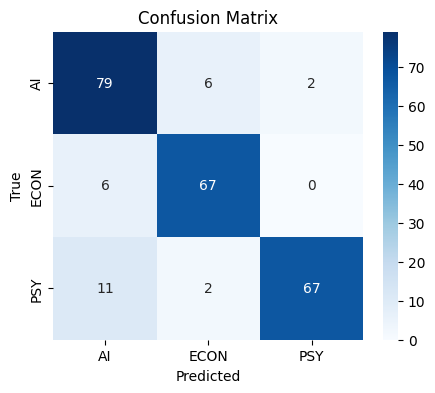

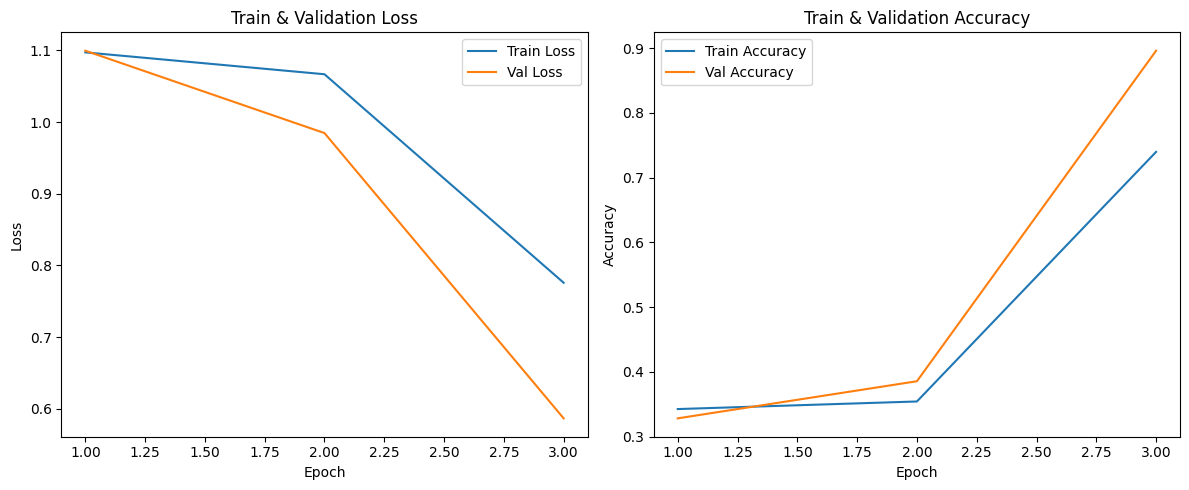

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DebertaTokenizer,
    DebertaForSequenceClassification,
    AdamW,
    get_scheduler
)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# (Varsayım) data = [(text, label_name), ...]
# label2idx = {"AI": 0, "ECON": 1, "PSY": 2}


X = [text for (text, lbl) in data]
y = [label2idx[lbl] for (text, lbl) in data]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Train set:", len(X_train))
print("Val set  :", len(X_val))
print("Test set :", len(X_test))

############################################
# 1. DeBERTa Tokenizer
############################################

PRETRAINED_MODEL_NAME = "microsoft/deberta-base"

tokenizer = DebertaTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
MAX_LEN = 128

############################################
# 2. Dataset & DataLoader
############################################

class DebertaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

train_dataset = DebertaDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset   = DebertaDataset(X_val,   y_val,   tokenizer, MAX_LEN)
test_dataset  = DebertaDataset(X_test,  y_test,  tokenizer, MAX_LEN)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

############################################
# 3. DeBERTa Model
############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_LABELS = 3  # "AI", "ECON", "PSY" etiket sayısı

model = DebertaForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME,
    num_labels=NUM_LABELS
).to(device)

############################################
# 4. Optimizasyon and Scheduler
############################################


EPOCHS = 3

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = EPOCHS * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

############################################
# 5. Training
############################################

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total   += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total   += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

############################################

############################################

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, lr_scheduler, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f},   Val acc:   {val_acc:.4f}")

############################################
# 7. Test Set
############################################

test_loss, test_acc = eval_epoch(model, test_loader, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

############################################
# 8. Confusion Matrix & Classification Report
############################################

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["AI", "ECON", "PSY"]))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["AI", "ECON", "PSY"],
            yticklabels=["AI", "ECON", "PSY"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

############################################

############################################

epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    DebertaTokenizer,
    DebertaForSequenceClassification,
    AdamW,
    get_scheduler
)
import numpy as np



BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask,
                        labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids,
                            attention_mask=attention_mask,
                            labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def train_and_evaluate(learning_rate, epochs, model_name="microsoft/deberta-base"):

    model = DebertaForSequenceClassification.from_pretrained(model_name, num_labels=3).to(device)

    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
    num_training_steps = epochs * len(train_loader)
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

    best_val_acc = 0.0
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
        val_loss, val_acc = eval_epoch(model, val_loader, device)


        print(f"Epoch {epoch+1}/{epochs} | LR={learning_rate}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f},   Val   Acc: {val_acc:.4f}")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()


    model.load_state_dict(best_model_state)
    return model, best_val_acc

###############################################
# Grid Search : Different LR and Epoch
###############################################

learning_rates = [1e-5, 2e-5, 3e-5]
epoch_list = [3, 5]

best_config = None
best_accuracy = 0.0
best_model = None

for lr in learning_rates:
    for ep in epoch_list:
        print(f"\n=== Deneniyor => Learning Rate: {lr}, Epochs: {ep} ===\n")
        model_candidate, val_acc = train_and_evaluate(lr, ep)
        print(f"  => Val Accuracy: {val_acc:.4f}")

        if val_acc > best_accuracy:
            best_accuracy = val_acc
            best_config = (lr, ep)
            best_model = model_candidate

print("\n=============================================")
print(f"En iyi sonuç => LR={best_config[0]}, Epochs={best_config[1]}, Val Acc={best_accuracy:.4f}")
print("=============================================")

test_loss, test_acc = eval_epoch(best_model, test_loader, device)
print(f"\n**Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}**")



=== Deneniyor => Learning Rate: 1e-05, Epochs: 3 ===



Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 | LR=1e-05
  Train Loss: 1.0927, Train Acc: 0.3294
  Val   Loss: 1.0333,   Val   Acc: 0.4688
Epoch 2/3 | LR=1e-05
  Train Loss: 1.0251, Train Acc: 0.5039
  Val   Loss: 0.9549,   Val   Acc: 0.5469
Epoch 3/3 | LR=1e-05
  Train Loss: 0.9548, Train Acc: 0.5690
  Val   Loss: 0.9351,   Val   Acc: 0.5990
  => Val Accuracy: 0.5990

=== Deneniyor => Learning Rate: 1e-05, Epochs: 5 ===



Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | LR=1e-05
  Train Loss: 1.0913, Train Acc: 0.3659
  Val   Loss: 0.9864,   Val   Acc: 0.5469
Epoch 2/5 | LR=1e-05
  Train Loss: 0.6725, Train Acc: 0.7956
  Val   Loss: 0.3302,   Val   Acc: 0.9167
Epoch 3/5 | LR=1e-05
  Train Loss: 0.2716, Train Acc: 0.9297
  Val   Loss: 0.1904,   Val   Acc: 0.9531
Epoch 4/5 | LR=1e-05
  Train Loss: 0.1619, Train Acc: 0.9622
  Val   Loss: 0.1610,   Val   Acc: 0.9583
Epoch 5/5 | LR=1e-05
  Train Loss: 0.1228, Train Acc: 0.9779
  Val   Loss: 0.1592,   Val   Acc: 0.9531
  => Val Accuracy: 0.9583

=== Deneniyor => Learning Rate: 2e-05, Epochs: 3 ===



Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | LR=2e-05
  Train Loss: 1.1017, Train Acc: 0.3112
  Val   Loss: 1.0983,   Val   Acc: 0.3229
Epoch 2/3 | LR=2e-05
  Train Loss: 1.0975, Train Acc: 0.3398
  Val   Loss: 1.0976,   Val   Acc: 0.3281
Epoch 3/3 | LR=2e-05
  Train Loss: 1.0984, Train Acc: 0.3385
  Val   Loss: 1.0961,   Val   Acc: 0.3281
  => Val Accuracy: 0.3281

=== Deneniyor => Learning Rate: 2e-05, Epochs: 5 ===



Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | LR=2e-05
  Train Loss: 1.0351, Train Acc: 0.4219
  Val   Loss: 0.6710,   Val   Acc: 0.7500
Epoch 2/5 | LR=2e-05
  Train Loss: 0.3698, Train Acc: 0.8646
  Val   Loss: 0.2048,   Val   Acc: 0.9427
Epoch 3/5 | LR=2e-05
  Train Loss: 0.1565, Train Acc: 0.9596
  Val   Loss: 0.1296,   Val   Acc: 0.9635
Epoch 4/5 | LR=2e-05
  Train Loss: 0.0811, Train Acc: 0.9818
  Val   Loss: 0.1826,   Val   Acc: 0.9375
Epoch 5/5 | LR=2e-05
  Train Loss: 0.0532, Train Acc: 0.9922
  Val   Loss: 0.1357,   Val   Acc: 0.9635
  => Val Accuracy: 0.9635

=== Deneniyor => Learning Rate: 3e-05, Epochs: 3 ===



Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 | LR=3e-05
  Train Loss: 0.8953, Train Acc: 0.5365
  Val   Loss: 0.2434,   Val   Acc: 0.9375
Epoch 2/3 | LR=3e-05
  Train Loss: 0.2373, Train Acc: 0.9180
  Val   Loss: 0.1888,   Val   Acc: 0.9323
Epoch 3/3 | LR=3e-05
  Train Loss: 0.0973, Train Acc: 0.9766
  Val   Loss: 0.1331,   Val   Acc: 0.9479
  => Val Accuracy: 0.9479

=== Deneniyor => Learning Rate: 3e-05, Epochs: 5 ===



Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5 | LR=3e-05
  Train Loss: 1.0024, Train Acc: 0.4505
  Val   Loss: 0.4271,   Val   Acc: 0.8958
Epoch 2/5 | LR=3e-05
  Train Loss: 0.3410, Train Acc: 0.8893
  Val   Loss: 0.1944,   Val   Acc: 0.9271
Epoch 3/5 | LR=3e-05
  Train Loss: 0.1189, Train Acc: 0.9661
  Val   Loss: 0.1689,   Val   Acc: 0.9479
Epoch 4/5 | LR=3e-05
  Train Loss: 0.0517, Train Acc: 0.9870
  Val   Loss: 0.1703,   Val   Acc: 0.9427
Epoch 5/5 | LR=3e-05
  Train Loss: 0.0207, Train Acc: 0.9987
  Val   Loss: 0.1735,   Val   Acc: 0.9427
  => Val Accuracy: 0.9479

En iyi sonuç => LR=2e-05, Epochs=5, Val Acc=0.9635

**Test Loss: 0.1547 | Test Acc: 0.9583**


Train set: 768
Val set  : 192
Test set : 240


Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5
  Train loss: 1.1053, Train acc: 0.3307
  Val   loss: 1.0968,   Val acc:   0.3229
Epoch 2/5
  Train loss: 1.0971, Train acc: 0.3581
  Val   loss: 1.0859,   Val acc:   0.7708
Epoch 3/5
  Train loss: 0.6105, Train acc: 0.7786
  Val   loss: 0.2522,   Val acc:   0.9062
Epoch 4/5
  Train loss: 0.1883, Train acc: 0.9414
  Val   loss: 0.1463,   Val acc:   0.9479
Epoch 5/5
  Train loss: 0.1036, Train acc: 0.9688
  Val   loss: 0.1309,   Val acc:   0.9531

Test Loss: 0.1849, Test Acc: 0.9375
Confusion Matrix:
 [[81  5  1]
 [ 3 69  1]
 [ 2  3 75]]

Classification Report:

              precision    recall  f1-score   support

          AI       0.94      0.93      0.94        87
        ECON       0.90      0.95      0.92        73
         PSY       0.97      0.94      0.96        80

    accuracy                           0.94       240
   macro avg       0.94      0.94      0.94       240
weighted avg       0.94      0.94      0.94       240



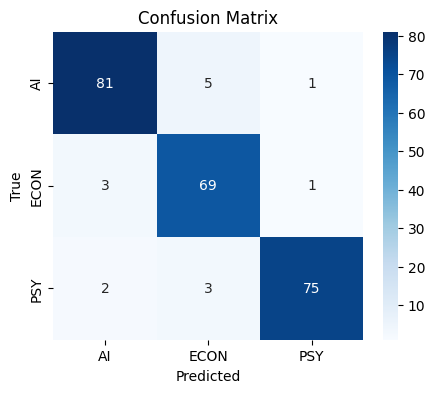

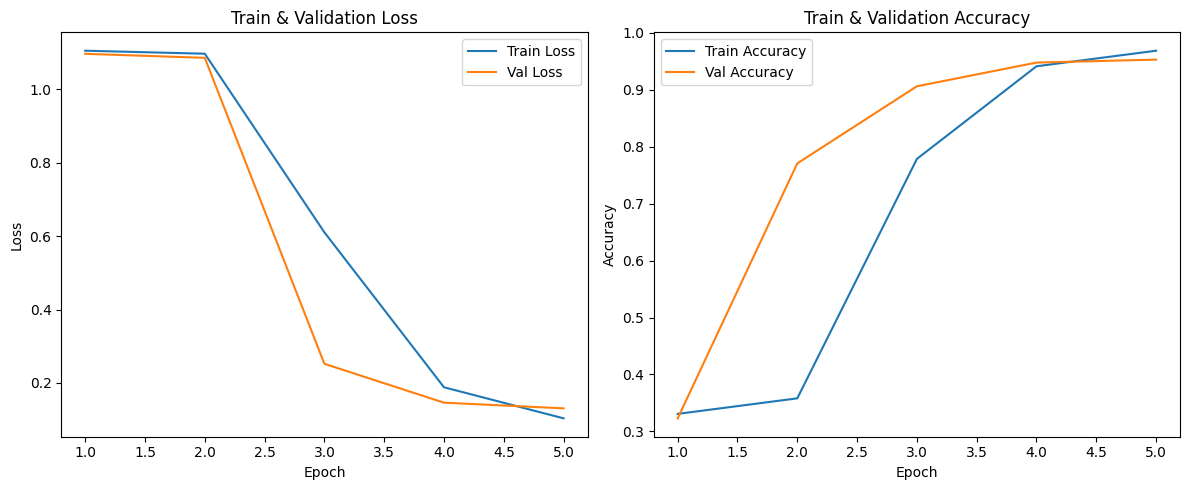

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    DebertaTokenizer,
    DebertaForSequenceClassification,
    AdamW,
    get_scheduler
)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

X = [text for (text, lbl) in data]
y = [label2idx[lbl] for (text, lbl) in data]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print("Train set:", len(X_train))
print("Val set  :", len(X_val))
print("Test set :", len(X_test))

############################################
# 1. DeBERTa Tokenizer
############################################

PRETRAINED_MODEL_NAME = "microsoft/deberta-base"

tokenizer = DebertaTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)
MAX_LEN = 128

############################################
# 2. Dataset & DataLoader
############################################

class DebertaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )

        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

train_dataset = DebertaDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset   = DebertaDataset(X_val,   y_val,   tokenizer, MAX_LEN)
test_dataset  = DebertaDataset(X_test,  y_test,  tokenizer, MAX_LEN)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

############################################
# 3. DeBERTa Model
############################################

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_LABELS = 3  # "AI", "ECON", "PSY" etiket sayısı

model = DebertaForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME,
    num_labels=NUM_LABELS
).to(device)

############################################
# 4. Optimizasyon and Scheduler
############################################


EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = EPOCHS * len(train_loader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

############################################
# 5. Training
############################################

def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total   += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total   += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

############################################

############################################

train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, lr_scheduler, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS}")
    print(f"  Train loss: {train_loss:.4f}, Train acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f},   Val acc:   {val_acc:.4f}")

############################################
Test
############################################

test_loss, test_acc = eval_epoch(model, test_loader, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

############################################
#Confusion Matrix & Classification Report
############################################

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["AI", "ECON", "PSY"]))

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["AI", "ECON", "PSY"],
            yticklabels=["AI", "ECON", "PSY"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

############################################
# Graphs
############################################

epochs_range = range(1, EPOCHS + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


#RoBERTa

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3 - LR: 2e-05
  Train Loss: 0.6956, Train Acc: 0.7057
  Val   Loss: 0.2292,   Val   Acc: 0.9323
Epoch 2/3 - LR: 2e-05
  Train Loss: 0.2436, Train Acc: 0.9232
  Val   Loss: 0.1745,   Val   Acc: 0.9427
Epoch 3/3 - LR: 2e-05
  Train Loss: 0.1543, Train Acc: 0.9557
  Val   Loss: 0.1505,   Val   Acc: 0.9479

Test Loss: 0.1960, Test Acc: 0.9250

Confusion Matrix:
 [[79  4  4]
 [ 3 67  3]
 [ 2  2 76]]

Classification Report:

              precision    recall  f1-score   support

          AI       0.94      0.91      0.92        87
        ECON       0.92      0.92      0.92        73
         PSY       0.92      0.95      0.93        80

    accuracy                           0.93       240
   macro avg       0.92      0.93      0.92       240
weighted avg       0.93      0.93      0.92       240



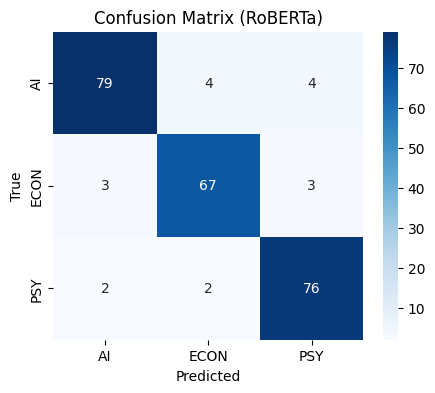

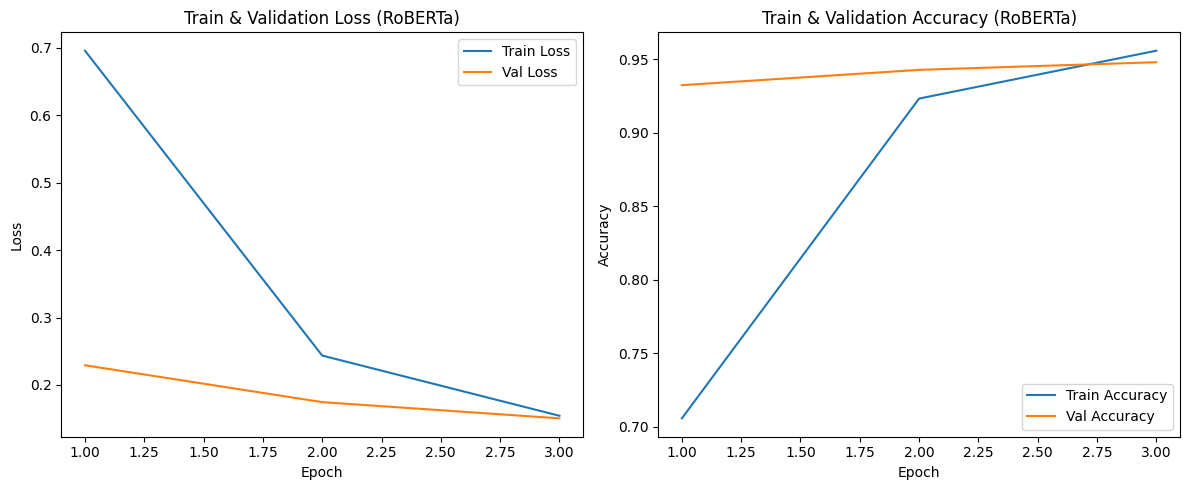

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    AdamW,
    get_scheduler
)
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report


# =====================================
# 1. Tokenizer
# =====================================
PRETRAINED_MODEL_NAME = "roberta-base"  # Dilerseniz "roberta-large" z
tokenizer = RobertaTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

# =====================================
# 2. Dataloaders
# =====================================

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# =====================================
# 3. RoBERTa Model
# =====================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_LABELS = 3  # (AI, ECON, PSY)

model = RobertaForSequenceClassification.from_pretrained(
    PRETRAINED_MODEL_NAME,
    num_labels=NUM_LABELS
).to(device)

# =====================================
# 4. Optimizasyon & Scheduler
# =====================================

EPOCHS = 3
learning_rate = 2e-5

optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)
num_training_steps = EPOCHS * len(train_loader)


lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

# =====================================

# =====================================
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in data_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += len(labels)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

# =====================================

# =====================================
train_losses = []
val_losses = []
train_accs = []
val_accs = []

best_val_acc = 0.0
best_model_state = None

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, lr_scheduler, device)
    val_loss, val_acc = eval_epoch(model, val_loader, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{EPOCHS} - LR: {learning_rate}")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f},   Val   Acc: {val_acc:.4f}")


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()


model.load_state_dict(best_model_state)

# =====================================
#  Test Set
# =====================================
test_loss, test_acc = eval_epoch(model, test_loader, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

# =====================================
#  Confusion Matrix & Classification Report
# =====================================
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=["AI","ECON","PSY"]))

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["AI","ECON","PSY"],
            yticklabels=["AI","ECON","PSY"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (RoBERTa)")
plt.show()

# =====================================
#
# =====================================
epochs_range = range(1, EPOCHS+1)
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Validation Loss (RoBERTa)")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train & Validation Accuracy (RoBERTa)")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
############################################
import requests
import xml.etree.ElementTree as ET
import random
import re
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import requests
import xml.etree.ElementTree as ET
import random
import re
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch.nn as nn
import torch.nn.functional as F
import re
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import requests
import xml.etree

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter


#######################
#######################

In [ ]:
import requests
import xml.etree.ElementTree as ET
import html

def fetch_arxiv_data_chunked(query, total_results, label, chunk_size=100):

    summaries = []
    start = 0

    while start < total_results:
        results_this_chunk = min(chunk_size, total_results - start)

        url = (
            "http://export.arxiv.org/api/query"
            f"?search_query={query}"
            f"&start={start}"
            f"&max_results={results_this_chunk}"
        )
        response = requests.get(url)

        try:
            root = ET.fromstring(response.content)
        except ET.ParseError as e:
            print(f"[UYARI] ParseError! It handles the chunk: start={start}, size={results_this_chunk}")
            print(f"        Error Detail: {e}")

            start += results_this_chunk
            continue

        # XML düzgün parse edildiyse entry'leri alalım
        for entry in root.findall('{http://www.w3.org/2005/Atom}entry'):
            summary_el = entry.find('{http://www.w3.org/2005/Atom}summary')
            if summary_el is not None:
                # Özel karakterleri XML uyumlu hale getirelim
                summary_text = summary_el.text.strip()
                summary_text = html.escape(summary_text)
                summaries.append((summary_text, label))

        start += results_this_chunk

    return summaries
# Aynı kategoriler:
#  - cat:cs.AI  --> AI
#  - cat:q-fin.EC -> ECON
#  - cat:cs.SI  --> PSY

# Chunk yaklaşımıyla çekelim
ai_articles = fetch_arxiv_data_chunked("cat:cs.AI", 1000, "AI", chunk_size=80)
ec_articles = fetch_arxiv_data_chunked("cat:q-fin.EC", 1000, "ECON", chunk_size=80)
ps_articles = fetch_arxiv_data_chunked("cat:cs.SI", 1000, "PSY", chunk_size=80)

data = ai_articles + ec_articles + ps_articles


[UYARI] ParseError! It handles the chunk: start=480, size=80
        Error Detail: not well-formed (invalid token): line 575, column 70


In [ ]:
print("AI Article:", len(ai_articles))
print("ECON Article:", len(ec_articles))
print("PSY Article:", len(ps_articles))

AI Article: 880
ECON Article: 920
PSY Article: 920


In [ ]:
#Save the data
import pickle

# Save the fetched data into a pickle file
output_file_path = '/content/arxiv_data_3000.pkl'
with open(output_file_path, 'wb') as file:
    pickle.dump(data, file)

output_file_path

'/content/arxiv_data_3000.pkl'

In [ ]:
###Read from the saved file

import pickle

# Read from the file Pickle
file_path = 'arxiv_data_3000.pkl'
with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Check data
print(f"Total Data: {len(data)}")
print("Sample Data:", data[:5])  # First five data


Total Data: 2720
Sample Data: [('Because of their occasional need to return to shallow points in a search\ntree, existing backtracking methods can sometimes erase meaningful progress\ntoward solving a search problem. In this paper, we present a method by which\nbacktrack points can be moved deeper in the search space, thereby avoiding this\ndifficulty. The technique developed is a variant of dependency-directed\nbacktracking that uses only polynomial space while still providing useful\ncontrol information and retaining the completeness guarantees provided by\nearlier approaches.', 'AI'), ('Market price systems constitute a well-understood class of mechanisms that\nunder certain conditions provide effective decentralization of decision making\nwith minimal communication overhead. In a market-oriented programming approach\nto distributed problem solving, we derive the activities and resource\nallocations for a set of computational agents by computing the competitive\nequilibrium of an ar

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
from gensim import corpora
from gensim.models import LdaModel
from nltk.tokenize import word_tokenize
import random
import re
import nltk


# Simplified stop words
simplified_stop_words = set([
    "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours","We","the",
    "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
    "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
    "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
    "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does",
    "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
    "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
    "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
    "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
    "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
    "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "scheduling", "approach", "data", "road", "used","The","impact","road", "authors", "leads", "grey","In","This","show","using","Use",
    'a','about','above','affect','after','again','against','all','am','an','and','any','approach','are','as','at','authors','be','because','been','before','being','below','between','both','but','by','can','case','constrain','data','did','do','does','doing','don','down','during','dynamic','each','effect','few','for','from','further','given','grey',
    'had','has','have','having','he','her','here','hers','herself','him','himself','his',
 'how','i','if','impact','in','into', 'is','it','its','itself','just','l','leads','link','me','more','most','my','myself','no','nor','not','now','obtain','of','off','on','once','only','or','other','our',
 'ours','ourselves','out','over','own','provide','road','s','same','scheduling','she','should','so','some','such','t','than','that','the','their','theirs', 'them','themselves','then','there','these',
 'they','this','those','through','to','too', 'tweet','under','until','up','used','very', 'was','we', 'were', 'what','when','where', 'which', 'while','who', 'whom', 'why','will','with','you','your','yours','yourself','yourselves'
,'model','based','users','paper','Our','new','results','also','method'])


# Label encoding
label2idx = {"AI": 0, "ECON": 1, "PSY": 2}

X = [text for (text, lbl) in data]
y = [label2idx[lbl] for (text, lbl) in data]

# Splitting the data
X_temp, X_test_text, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_text, X_val_text, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Preprocessing
nltk.download('punkt_tab')
import nltk
processed_texts = [
    [word for word in word_tokenize(re.sub(r'[^\w\s]', '', abstract.lower())) if word not in simplified_stop_words]
    for abstract in X_train_text + X_val_text + X_test_text
]


# Data preparation
ai_summaries = " ".join([item[0] for item in data if item[1] == "AI"])
all_words = " ".join([item[0] for item in data]).split()
summaries = [item[0] for item in data]
labels = [item[1] for item in data]
label_lengths = {label: [] for label in set(labels)}

econ_summaries = " ".join([item[0] for item in data if item[1] == "ECON"])
all_words = " ".join([item[0] for item in data]).split()
summaries = [item[0] for item in data]
labels = [item[1] for item in data]
label_lengths = {label: [] for label in set(labels)}

psy_summaries = " ".join([item[0] for item in data if item[1] == "PSY"])
all_words = " ".join([item[0] for item in data]).split()
summaries = [item[0] for item in data]
labels = [item[1] for item in data]
label_lengths = {label: [] for label in set(labels)}


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


#LSTM

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Toplam veri: 2720
Örnek veri: ('Because of their occasional need to return to shallow points in a search\ntree, existing backtracking methods can sometimes erase meaningful progress\ntoward solving a search problem. In this paper, we present a method by which\nbacktrack points can be moved deeper in the search space, thereby avoiding this\ndifficulty. The technique developed is a variant of dependency-directed\nbacktracking that uses only polynomial space while still providing useful\ncontrol information and retaining the completeness guarantees provided by\nearlier approaches.', 'AI')
Final Vocab Size: 4942
X_train_tensor shape: torch.Size([3808, 100])
y_train_tensor shape: torch.Size([3808])
Epoch [1/10] Train Loss: 0.8518, Train Acc: 0.6074, Val Loss: 0.5691, Val Acc: 0.7708
Epoch [2/10] Train Loss: 0.4989, Train Acc: 0.8128, Val Loss: 0.4128, Val Acc: 0.8419
Epoch [3/10] Train Loss: 0.3619, Train Acc: 0.8713, Val Loss: 0.3229, Val Acc: 0.8860
Epoch [4/10] Train Loss: 0.2977, Train 

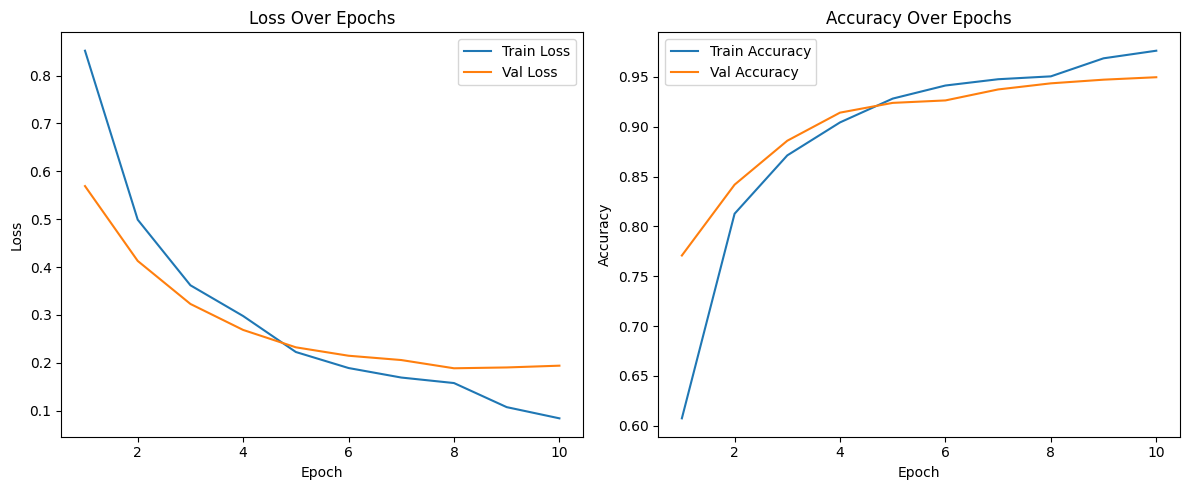

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from collections import Counter

###############################################################################
#  Reproducibility
###############################################################################
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

###############################################################################

###############################################################################
data = pd.read_pickle("/content/arxiv_data_3000.pkl")

if isinstance(data, list):
    print(f"Toplam veri: {len(data)}")
    print("Örnek veri:", data[0])  # İlk elemanı ekrana bas
else:
    raise ValueError("PKL dosyası beklenmeyen bir formatta. DataFrame veya list olmalı.")

###############################################################################
# 2) LABEL ENCODING
###############################################################################
label2idx = {"AI": 0, "ECON": 1, "PSY": 2}

###############################################################################
# 3) DATA AUGMENTATION - Synonym Replacement
###############################################################################
stop_words = set(stopwords.words("english"))

def get_synonym(word):
    synsets = wordnet.synsets(word)
    if not synsets:
        return None
    synonyms = [
        syn.lower().replace("_", " ")
        for syn in synsets[0].lemma_names()
        if syn.lower() != word.lower()
    ]
    return random.choice(synonyms) if synonyms else None

def augment_text_with_synonyms(text, n=1):
    """
    n=1 => Hafif synonym replacement
    """
    words = text.split()
    if len(words) < 2:
        return text
    content_word_indices = [
        i for i, w in enumerate(words)
        if w.lower() not in stop_words and re.match(r"^[a-zA-Z]+$", w)
    ]
    if len(content_word_indices) == 0:
        return text
    # choose random n number of word and replace them with synonyms
    random_indices = random.sample(content_word_indices, min(n, len(content_word_indices)))
    for idx in random_indices:
        synonym = get_synonym(words[idx])
        if synonym:
            words[idx] = synonym
    return " ".join(words)

###############################################################################

###############################################################################
def clean_text(text):


    text = re.sub(r"\$[^$]+\$", " ", text)


    text = re.sub(r"http\S+|www\S+", "", text)


    text = re.sub(r"\s+", " ", text).strip()
    return text

# Orijinal + Augment
augmented_rows = []
for original_text, label_str in data:

    original_text = clean_text(original_text)


    augmented_text = augment_text_with_synonyms(original_text, n=1)

    augmented_rows.append({"Summary": original_text, "Label": label_str})
    augmented_rows.append({"Summary": augmented_text, "Label": label_str})

df = pd.DataFrame(augmented_rows)
df["Label"] = df["Label"].map(label2idx)

###############################################################################
# 4) Tokenization
###############################################################################
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)
    return tokens

X = df["Summary"].tolist()
y = df["Label"].tolist()

# Train / Val / Test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=SEED
)

###############################################################################
# 5) PRETRAINED GLOVE EMBEDDING
###############################################################################
glove_path = "/content/glove.6B.100d.txt"  # GloVe file path
embedding_dim = 100

word2vec_map = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        # Önemli: Eklendi
        word2vec_map[word] = vector

###############################################################################
# 6) WORD2IDX and PAD SEQUENCES
###############################################################################
counter = Counter()
for text in X_train:
    tokens = tokenize(text)
    counter.update(tokens)

max_vocab_size = 5000
most_common_words = counter.most_common(max_vocab_size)

word2idx = {"<PAD>": 0, "<UNK>": 1}
idx2word = {0: "<PAD>", 1: "<UNK>"}
idx = 2
for word, _ in most_common_words:
    if word in word2vec_map:
        word2idx[word] = idx
        idx2word[idx] = word
        idx += 1

vocab_size = len(word2idx)
print("Final Vocab Size:", vocab_size)

# Embedding matrix
embedding_matrix = np.random.normal(scale=0.05, size=(vocab_size, embedding_dim)).astype("float32")

for word, i in word2idx.items():
    if word in word2vec_map:
        embedding_matrix[i] = word2vec_map[word]

def text_to_ids(text):
    tokens = tokenize(text)
    ids = [word2idx.get(t, word2idx["<UNK>"]) for t in tokens]
    return ids

def pad_sequence_fn(seq, max_len=100):
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))
    return seq[:max_len]

def convert_and_pad(text_list, max_len=100):
    all_ids = [pad_sequence_fn(text_to_ids(txt), max_len) for txt in text_list]
    return torch.LongTensor(all_ids)

X_train_tensor = convert_and_pad(X_train)
X_val_tensor   = convert_and_pad(X_val)
X_test_tensor  = convert_and_pad(X_test)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor   = torch.LongTensor(y_val)
y_test_tensor  = torch.LongTensor(y_test)

print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)

###############################################################################
# 7) PYTORCH DATASET & DATALOADER
###############################################################################
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 16
train_dataset = TextDataset(X_train_tensor, y_train_tensor)
val_dataset   = TextDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TextDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  drop_last=False)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

###############################################################################
# 8) LSTM MODEL + CLASSIFIER
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class LSTMEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 num_layers=1, bidirectional=False, dropout=0.0, emb_matrix=None):
        super(LSTMEncoder, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        if emb_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_matrix))

        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim

    def forward(self, x):
        embedded = self.embedding(x)
        outputs, (h_n, c_n) = self.lstm(embedded)
        if self.directions == 1:
            final_state = h_n[-1, :, :]
        else:
            forward_h = h_n[-2, :, :]
            backward_h = h_n[-1, :, :]
            final_state = torch.cat((forward_h, backward_h), dim=1)
        return final_state

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=3, dropout=0.5):
        super(Classifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

###############################################################################

###############################################################################
EMBED_DIM     = embedding_dim  # 100
HIDDEN_DIM    = 128
NUM_LAYERS    = 2
BIDIRECTIONAL = True
LSTM_DROPOUT  = 0.5
FC_DROPOUT    = 0.5

encoder_model = LSTMEncoder(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=LSTM_DROPOUT,
    emb_matrix=embedding_matrix
).to(device)

clf_input_dim = HIDDEN_DIM * (2 if BIDIRECTIONAL else 1)
clf_model = Classifier(clf_input_dim, num_classes=3, dropout=FC_DROPOUT).to(device)

###############################################################################
# 8.2) CrossEntropyLoss adding Class Weight
###############################################################################
:
y_train_counts = pd.Series(y_train).value_counts().sort_index().values

class_weights = 1.0 / torch.tensor(y_train_counts, dtype=torch.float)
class_weights = class_weights / class_weights.sum() * 3.0  # normalizasyon
class_weights = class_weights.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)


###############################################################################
# 9)  TRAIN + VALIDATION
###############################################################################

optimizer = torch.optim.Adam(
    list(encoder_model.parameters()) + list(clf_model.parameters()),
    lr=3e-4,
    weight_decay=1e-4
)

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

def evaluate(encoder, classifier, data_loader, criterion, device):
    encoder.eval()
    classifier.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            feats = encoder(X_batch)
            logits = classifier(feats)
            loss = criterion(logits, y_batch)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == y_batch).sum().item()
            total_count += len(y_batch)

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / total_count
    return avg_loss, avg_acc

def compute_metrics(encoder_model, clf_model, data_loader, device):
    encoder_model.eval()
    clf_model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            features = encoder_model(X_batch)
            logits = clf_model(features)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    report = classification_report(
        all_labels,
        all_preds,
        digits=4,
        target_names=["AI", "ECON", "PSY"]
    )
    print("Classification Report:\n", report)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average='macro'
    )
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall:    {recall:.4f}")
    print(f"Macro F1-score:  {f1_score:.4f}")

EPOCHS = 10
best_val_acc = 0.0
no_improve_count = 0
patience = 3

best_encoder_state = None
best_clf_state = None

for epoch in range(EPOCHS):
    encoder_model.train()
    clf_model.train()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        feats = encoder_model(X_batch)
        logits = clf_model(feats)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == y_batch).sum().item()
        running_total += len(y_batch)

    train_loss = running_loss / len(train_loader)
    train_acc = running_correct / running_total

    val_loss, val_acc = evaluate(encoder_model, clf_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Early Stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_encoder_state = encoder_model.state_dict()
        best_clf_state = clf_model.state_dict()
        no_improve_count = 0
    else:
        no_improve_count += 1
        if no_improve_count >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break


if best_encoder_state:
    encoder_model.load_state_dict(best_encoder_state)
    clf_model.load_state_dict(best_clf_state)

###############################################################################
# 10) TEST Performance
###############################################################################
test_loss, test_acc = evaluate(encoder_model, clf_model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

compute_metrics(encoder_model, clf_model, test_loader, device)

###############################################################################

###############################################################################
plt.figure(figsize=(12,5))

# Loss Graph
plt.subplot(1,2,1)
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1), val_losses, label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(range(1, len(train_accs)+1), train_accs, label="Train Accuracy")
plt.plot(range(1, len(val_accs)+1), val_accs, label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


<Figure size 800x800 with 0 Axes>

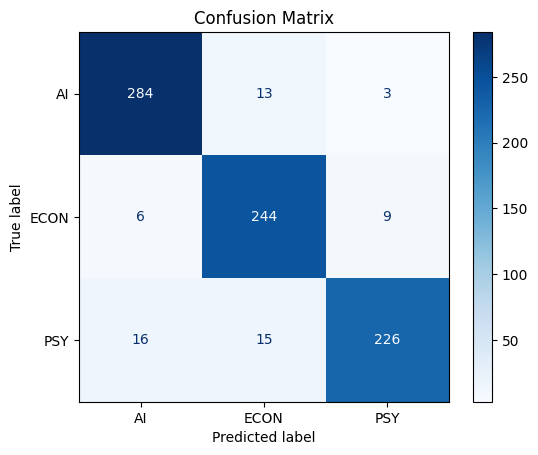

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(encoder_model, clf_model, data_loader, device, class_names):

    encoder_model.eval()
    clf_model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            features = encoder_model(X_batch)
            logits = clf_model(features)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

class_names = list(label2idx.keys())
plot_confusion_matrix(encoder_model, clf_model, test_loader, device, class_names)

#GRU


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Toplam veri: 2720
Örnek veri: ('Because of their occasional need to return to shallow points in a search\ntree, existing backtracking methods can sometimes erase meaningful progress\ntoward solving a search problem. In this paper, we present a method by which\nbacktrack points can be moved deeper in the search space, thereby avoiding this\ndifficulty. The technique developed is a variant of dependency-directed\nbacktracking that uses only polynomial space while still providing useful\ncontrol information and retaining the completeness guarantees provided by\nearlier approaches.', 'AI')
Final Vocab Size: 4943
X_train_tensor shape: torch.Size([3808, 100])
y_train_tensor shape: torch.Size([3808])
Epoch [1/10] Train Loss: 0.5547, Train Acc: 0.7681, Val Loss: 0.2340, Val Acc: 0.9326
Epoch [2/10] Train Loss: 0.1639, Train Acc: 0.9493, Val Loss: 0.1272, Val Acc: 0.9645
Epoch [3/10] Train Loss: 0.0610, Train Acc: 0.9837, Val Loss: 0.1123, Val Acc: 0.9694
Epoch [4/10] Train Loss: 0.0363, Train 

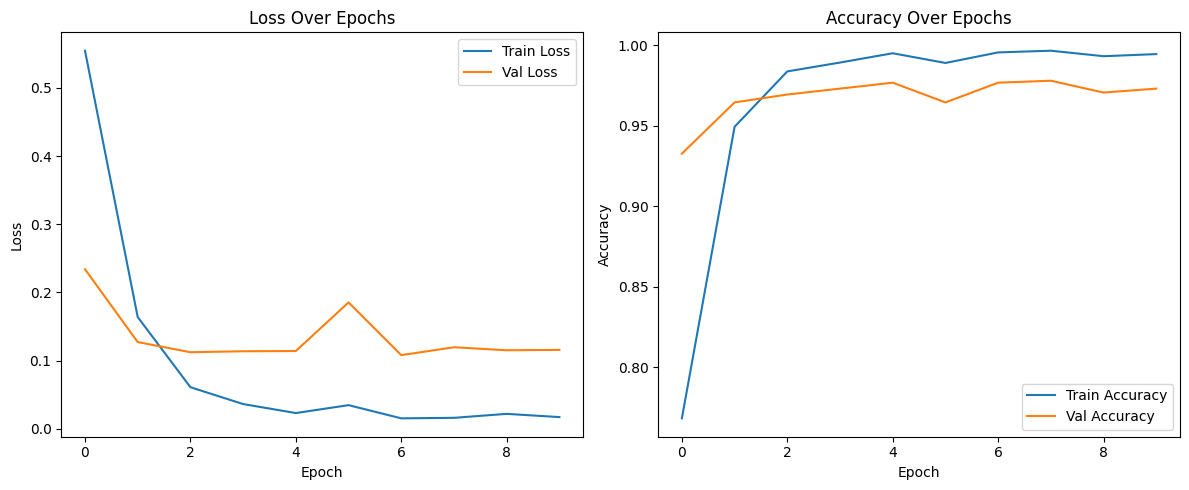

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random

import nltk
from nltk.corpus import stopwords, wordnet
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support
from collections import Counter

###############################################################################
# 1) Read Dataset
###############################################################################
data = pd.read_pickle("/content/arxiv_data_3000.pkl")

if isinstance(data, list):
    print(f"Toplam veri: {len(data)}")
    print("Örnek veri:", data[0])
else:
    raise ValueError("PKL dosyası beklenmeyen bir formatta. DataFrame veya list olmalı.")

###############################################################################
# 2) LABEL ENCODING
###############################################################################
label2idx = {"AI": 0, "ECON": 1, "PSY": 2}

###############################################################################
# 3) DATA AUGMENTATION - Synonym Replacement
###############################################################################
stop_words = set(stopwords.words("english"))

def get_synonym(word):
    synsets = wordnet.synsets(word)
    if not synsets:
        return None
    synonyms = [
        syn.lower().replace("_", " ")
        for syn in synsets[0].lemma_names()
        if syn.lower() != word.lower()
    ]
    return random.choice(synonyms) if synonyms else None

def augment_text_with_synonyms(text, n=2):
    words = text.split()
    if len(words) < 2:
        return text
    content_word_indices = [
        i for i, w in enumerate(words)
        if w.lower() not in stop_words and re.match(r"^[a-zA-Z]+$", w)
    ]
    if len(content_word_indices) == 0:
        return text
    random_indices = random.sample(content_word_indices, min(n, len(content_word_indices)))
    for idx in random_indices:
        synonym = get_synonym(words[idx])
        if synonym:
            words[idx] = synonym
    return " ".join(words)

# Original data + Augment data
augmented_rows = []
for original_text, label in data:
    augmented_text = augment_text_with_synonyms(original_text, n=3)
    augmented_rows.append({"Summary": original_text, "Label": label})
    augmented_rows.append({"Summary": augmented_text, "Label": label})

# DataFrame
augmented_df = pd.DataFrame(augmented_rows)

# Label 0,1,2
augmented_df["Label"] = augmented_df["Label"].map(label2idx)

###############################################################################
# 4) Tokenization and Cleaning
###############################################################################
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)
    return tokens

X = augmented_df["Summary"].tolist()
y = augmented_df["Label"].tolist()

# Train / Val / Test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

###############################################################################
# 5) PRETRAINED GLOVE EMBEDDING
###############################################################################
glove_path = "/content/glove.6B.100d.txt"  # GloVe path
embedding_dim = 100

word2vec_map = {}
with open(glove_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype="float32")
        word2vec_map[word] = vector

###############################################################################
# 6) WORD2IDX and PAD SEQUENCES
###############################################################################
counter = Counter()
for text in X_train:
    tokens = tokenize(text)
    counter.update(tokens)

max_vocab_size = 5000
most_common_words = counter.most_common(max_vocab_size)

word2idx = {"<PAD>": 0, "<UNK>": 1}
idx2word = {0: "<PAD>", 1: "<UNK>"}
idx = 2
for word, _ in most_common_words:

    if word in word2vec_map:
        word2idx[word] = idx
        idx2word[idx] = word
        idx += 1

vocab_size = len(word2idx)
print("Final Vocab Size:", vocab_size)

# Embedding matrix
embedding_matrix = np.random.normal(scale=0.05, size=(vocab_size, embedding_dim)).astype("float32")
for word, i in word2idx.items():
    if word in word2vec_map:
        embedding_matrix[i] = word2vec_map[word]

def text_to_ids(text):
    tokens = tokenize(text)
    ids = [word2idx.get(t, word2idx["<UNK>"]) for t in tokens]
    return ids

def pad_sequence_fn(seq, max_len=100):
    if len(seq) < max_len:
        return seq + [0] * (max_len - len(seq))
    return seq[:max_len]

def convert_and_pad(text_list, max_len=100):
    all_ids = [pad_sequence_fn(text_to_ids(txt), max_len) for txt in text_list]
    return torch.LongTensor(all_ids)

# Tensor
X_train_tensor = convert_and_pad(X_train)
X_val_tensor   = convert_and_pad(X_val)
X_test_tensor  = convert_and_pad(X_test)

y_train_tensor = torch.LongTensor(y_train)
y_val_tensor   = torch.LongTensor(y_val)
y_test_tensor  = torch.LongTensor(y_test)

print("X_train_tensor shape:", X_train_tensor.shape)
print("y_train_tensor shape:", y_train_tensor.shape)

###############################################################################
# 7) PYTORCH DATASET & DATALOADER
###############################################################################
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

BATCH_SIZE = 4
train_dataset = TextDataset(X_train_tensor, y_train_tensor)
val_dataset   = TextDataset(X_val_tensor,   y_val_tensor)
test_dataset  = TextDataset(X_test_tensor,  y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

###############################################################################
# 8) GRU MODEL + CLASSIFIER
###############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GRUEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 num_layers=1, bidirectional=False, dropout=0.0, emb_matrix=None):
        super(GRUEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)


        if emb_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(emb_matrix))

        # GRU
        self.gru = nn.GRU(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )

        self.directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim

    def forward(self, x):
        # x: [batch_size, seq_len]
        embedded = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        outputs, h_n = self.gru(embedded)
        # h_n: [num_layers * directions, batch_size, hidden_size]

        if self.directions == 1:

            final_state = h_n[-1, :, :]
        else:

            forward_h = h_n[-2, :, :]
            backward_h = h_n[-1, :, :]
            final_state = torch.cat((forward_h, backward_h), dim=1)

        return final_state

class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=3, dropout=0.5):
        super(Classifier, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        x = self.dropout(x)
        logits = self.fc(x)
        return logits

# Hyperparamaters
EMBED_DIM     = embedding_dim  # GloVe dimension (100)
HIDDEN_DIM    = 64
NUM_LAYERS    = 1
BIDIRECTIONAL = True
GRU_DROPOUT   = 0.5
FC_DROPOUT    = 0.5

encoder_model = GRUEncoder(
    vocab_size=vocab_size,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=GRU_DROPOUT,
    emb_matrix=embedding_matrix
).to(device)

clf_input_dim = HIDDEN_DIM * (2 if BIDIRECTIONAL else 1)
clf_model = Classifier(clf_input_dim, num_classes=3, dropout=FC_DROPOUT).to(device)

###############################################################################
# 9)  TRAIN + VALIDATION
###############################################################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    list(encoder_model.parameters()) + list(clf_model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)

train_losses = []
val_losses   = []
train_accs   = []
val_accs     = []

def evaluate(encoder, classifier, data_loader, criterion, device):
    encoder.eval()
    classifier.eval()
    total_loss = 0.0
    total_correct = 0
    total_count = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            feats = encoder(X_batch)
            logits = classifier(feats)
            loss = criterion(logits, y_batch)

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            total_correct += (preds == y_batch).sum().item()
            total_count += len(y_batch)

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / total_count
    return avg_loss, avg_acc

def compute_metrics(encoder_model, clf_model, data_loader, device):
    encoder_model.eval()
    clf_model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            features = encoder_model(X_batch)
            logits = clf_model(features)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Classification Report
    report = classification_report(
        all_labels,
        all_preds,
        digits=4,
        target_names=label2idx.keys()
    )
    print("Classification Report:\n", report)

    precision, recall, f1_score, _ = precision_recall_fscore_support(
        all_labels,
        all_preds,
        average='macro'
    )
    print(f"Macro Precision: {precision:.4f}")
    print(f"Macro Recall:    {recall:.4f}")
    print(f"Macro F1-score:  {f1_score:.4f}")


EPOCHS = 10
best_val_acc = 0.0

for epoch in range(EPOCHS):
    encoder_model.train()
    clf_model.train()

    running_loss = 0.0
    running_correct = 0
    running_total = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        feats = encoder_model(X_batch)
        logits = clf_model(feats)
        loss = criterion(logits, y_batch)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == y_batch).sum().item()
        running_total += len(y_batch)

    train_loss = running_loss / len(train_loader)
    train_acc = running_correct / running_total

    # Validation set
    val_loss, val_acc = evaluate(encoder_model, clf_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Check the best accuracy and validation
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_encoder_state = encoder_model.state_dict()
        best_clf_state = clf_model.state_dict()

# Load Best Model
encoder_model.load_state_dict(best_encoder_state)
clf_model.load_state_dict(best_clf_state)


###############################################################################
# 10) TEST Performance and Metrics
###############################################################################
test_loss, test_acc = evaluate(encoder_model, clf_model, test_loader, criterion, device)
print(f"\nTest Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

# F1, Precision, Recall
compute_metrics(encoder_model, clf_model, test_loader, device)

###############################################################################
# 11) Graphs
###############################################################################
plt.figure(figsize=(12,5))

# Loss Graph
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Accuracy Graph
plt.subplot(1,2,2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


<Figure size 800x800 with 0 Axes>

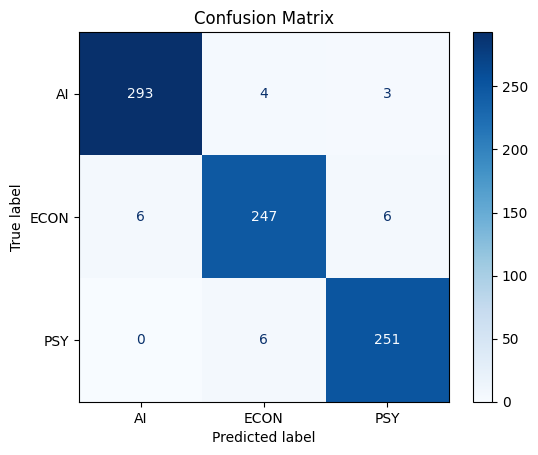

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(encoder_model, clf_model, data_loader, device, class_names):

    encoder_model.eval()
    clf_model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            features = encoder_model(X_batch)
            logits = clf_model(features)
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot confusion matrix
    plt.figure(figsize=(8, 8))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix")
    plt.show()

class_names = list(label2idx.keys())
plot_confusion_matrix(encoder_model, clf_model, test_loader, device, class_names)

#BERT

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
  Train Loss: 0.6116, Train Acc: 0.7483
  Val   Loss: 0.2375, Val   Acc: 0.9312
Epoch 2/3
  Train Loss: 0.1981, Train Acc: 0.9391
  Val   Loss: 0.1441, Val   Acc: 0.9541
Epoch 3/3
  Train Loss: 0.0869, Train Acc: 0.9770
  Val   Loss: 0.1464, Val   Acc: 0.9495

Test Loss: 0.2095, Test Acc: 0.9375
Confusion Matrix:
 [[168   3   5]
 [  6 168   8]
 [  3   9 174]]

Classification Report:
               precision    recall  f1-score   support

          AI       0.95      0.95      0.95       176
        ECON       0.93      0.92      0.93       182
         PSY       0.93      0.94      0.93       186

    accuracy                           0.94       544
   macro avg       0.94      0.94      0.94       544
weighted avg       0.94      0.94      0.94       544



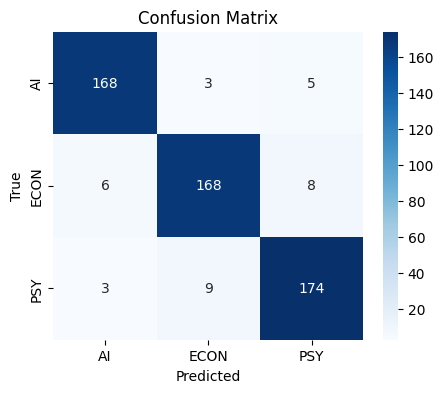

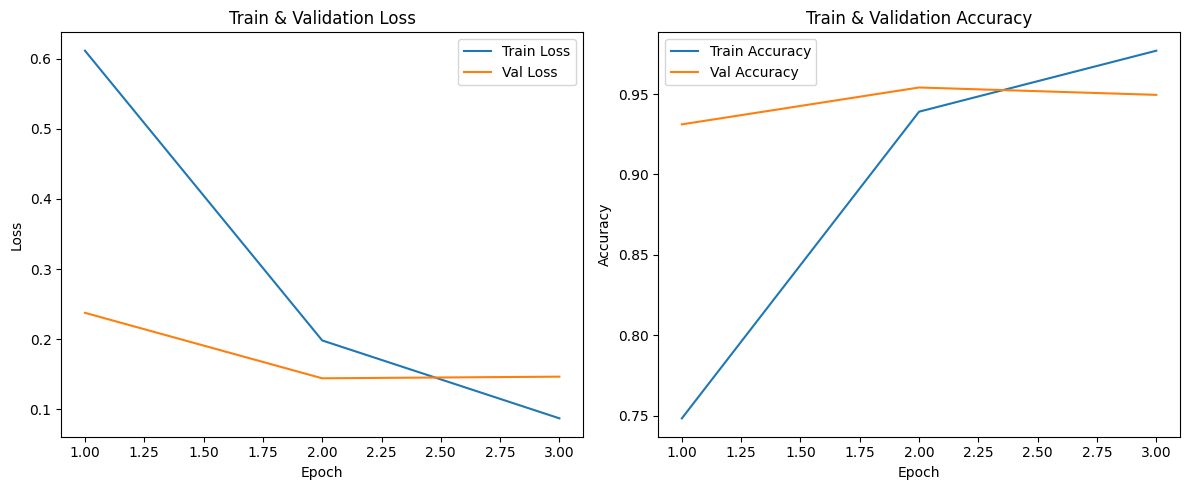

In [ ]:
############################################
# 0. Libraries
############################################

import requests
import xml.etree.ElementTree as ET
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    AdamW,
    get_scheduler
)

import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


############################################
# 2. BERT TOKENIZER and DATASET
############################################

PRETRAINED_MODEL_NAME = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

MAX_LEN = 128

class BertDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, tokenizer, max_len, batch_size):
    train_dataset = BertDataset(X_train, y_train, tokenizer, max_len)
    val_dataset   = BertDataset(X_val,   y_val,   tokenizer, max_len)
    test_dataset  = BertDataset(X_test,  y_test,  tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

############################################
# 3. Model
############################################

def create_model(num_labels=3, model_name=PRETRAINED_MODEL_NAME):
    model = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )
    return model

############################################

############################################

def train_epoch(model, data_loader, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

############################################
# 5. Main Training Loop
############################################

def train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=5,
    lr=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1
):
    """
    warmup_ratio: toplam adımların hangi oranını 'warmup' olarak ayıracağımız.
    """
    # AdamW optimizer
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)


    total_steps = epochs * len(train_loader)
    warmup_steps = int(total_steps * warmup_ratio)

    # Linear Scheduler
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    train_losses = []
    val_losses   = []
    train_accs   = []
    val_accs     = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, scheduler)
        val_loss, val_acc = eval_epoch(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()


    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, (train_losses, val_losses, train_accs, val_accs)

############################################
# 6. Test
############################################

def test_model(model, test_loader, device):
    test_loss, test_acc = eval_epoch(model, test_loader, device)
    print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Confusion matrix
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    print("Confusion Matrix:\n", cm)

    # Classification report
    cr = classification_report(all_labels, all_preds, target_names=["AI","ECON","PSY"])
    print("\nClassification Report:\n", cr)

    # Grafikte isterseniz CM plot
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["AI","ECON","PSY"],
                yticklabels=["AI","ECON","PSY"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

############################################
# 7. Plot
############################################

def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs_range = range(1, len(train_losses)+1)
    plt.figure(figsize=(12, 5))

    # Loss Graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train & Validation Loss")
    plt.legend()

    # Accuracy Graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label="Train Accuracy")
    plt.plot(epochs_range, val_accs,   label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train & Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

############################################

############################################


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=SEED)

# 2) DataLoader
BATCH_SIZE = 16
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    tokenizer,
    max_len=128,
    batch_size=BATCH_SIZE
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(num_labels=3, model_name="bert-base-uncased").to(device)


EPOCHS = 3
lr = 3e-5
weight_decay = 0.01
warmup_ratio = 0.1

model, (train_losses, val_losses, train_accs, val_accs) = train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=EPOCHS,
    lr=lr,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio
)

# 5) Test
test_model(model, test_loader, device)

# 6) Plot
plot_metrics(train_losses, val_losses, train_accs, val_accs)




#DeBERTa

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3
  Train Loss: 0.7852, Train Acc: 0.5914
  Val   Loss: 0.2863, Val   Acc: 0.9083
Epoch 2/3
  Train Loss: 0.2290, Train Acc: 0.9241
  Val   Loss: 0.2192, Val   Acc: 0.9243
Epoch 3/3
  Train Loss: 0.0901, Train Acc: 0.9730
  Val   Loss: 0.1835, Val   Acc: 0.9404

Test Loss: 0.2503, Test Acc: 0.9246
Confusion Matrix:
 [[163   7   6]
 [  8 167   7]
 [  4   9 173]]

Classification Report:
               precision    recall  f1-score   support

          AI       0.93      0.93      0.93       176
        ECON       0.91      0.92      0.92       182
         PSY       0.93      0.93      0.93       186

    accuracy                           0.92       544
   macro avg       0.92      0.92      0.92       544
weighted avg       0.92      0.92      0.92       544



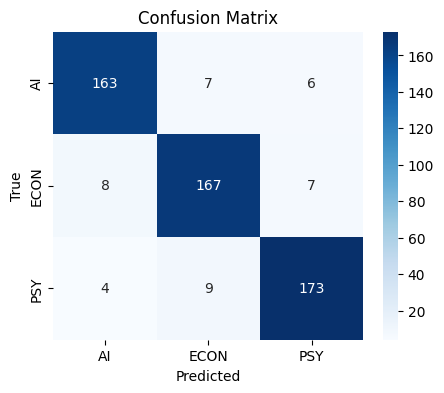

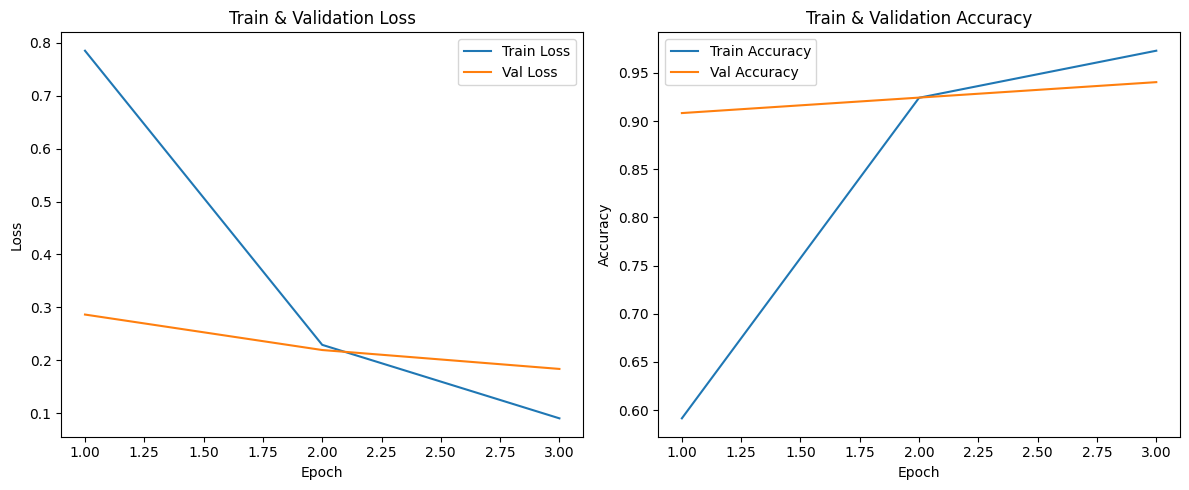

In [ ]:
############################################
# 0. Libraries
############################################

import requests
import xml.etree.ElementTree as ET
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# DeBERTa import
from transformers import (
    DebertaTokenizer,
    DebertaForSequenceClassification,
    AdamW,
    get_scheduler
)

import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)



############################################
# 2. DeBERTa TOKENIZER and DATASET
############################################

PRETRAINED_MODEL_NAME = "microsoft/deberta-base"  #  "microsoft/deberta-v3-base"
tokenizer = DebertaTokenizer.from_pretrained(PRETRAINED_MODEL_NAME)

MAX_LEN = 128

class DebertaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, tokenizer, max_len, batch_size):
    train_dataset = DebertaDataset(X_train, y_train, tokenizer, max_len)
    val_dataset   = DebertaDataset(X_val,   y_val,   tokenizer, max_len)
    test_dataset  = DebertaDataset(X_test,  y_test,  tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

############################################
# 3. Model
############################################

def create_model(num_labels=3, model_name=PRETRAINED_MODEL_NAME):
    model = DebertaForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )
    return model

############################################

############################################

def train_epoch(model, data_loader, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy

############################################
# 5. Main Training Loop
############################################

def train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=5,
    lr=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1
):
    """
    warmup_ratio: toplam adımların hangi oranını 'warmup' olarak ayıracağımız.
    """
    # AdamW optimizer
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)


    total_steps = epochs * len(train_loader)
    warmup_steps = int(total_steps * warmup_ratio)

    # Linear Scheduler
    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    train_losses = []
    val_losses   = []
    train_accs   = []
    val_accs     = []

    best_val_acc = 0.0
    best_model_state = None

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, scheduler)
        val_loss, val_acc = eval_epoch(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")


        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()


    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, (train_losses, val_losses, train_accs, val_accs)

############################################
#
############################################

def test_model(model, test_loader, device):
    test_loss, test_acc = eval_epoch(model, test_loader, device)
    print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Confusion matrix
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2])
    print("Confusion Matrix:\n", cm)


    cr = classification_report(all_labels, all_preds, target_names=["AI","ECON","PSY"])
    print("\nClassification Report:\n", cr)


    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["AI","ECON","PSY"],
                yticklabels=["AI","ECON","PSY"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

############################################
# 7. Plot
############################################

def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs_range = range(1, len(train_losses)+1)
    plt.figure(figsize=(12, 5))

    # Loss Graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train & Validation Loss")
    plt.legend()

    # Accuracy Graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label="Train Accuracy")
    plt.plot(epochs_range, val_accs,   label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train & Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

############################################

############################################


X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=SEED)

# 2) DataLoader
BATCH_SIZE = 16
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    tokenizer,
    max_len=128,
    batch_size=BATCH_SIZE
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(num_labels=3, model_name="microsoft/deberta-base").to(device)


EPOCHS = 3
lr = 4e-5
weight_decay = 0.01
warmup_ratio = 0.1

model, (train_losses, val_losses, train_accs, val_accs) = train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=EPOCHS,
    lr=lr,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio
)

# 5) Test
test_model(model, test_loader, device)

# 6) Plot
plot_metrics(train_losses, val_losses, train_accs, val_accs)



#RoBERTa

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
  Train Loss: 0.7855, Train Acc: 0.6138
  Val   Loss: 0.2474, Val   Acc: 0.8968
Epoch 2/5
  Train Loss: 0.2730, Train Acc: 0.8989
  Val   Loss: 0.1954, Val   Acc: 0.9312
Epoch 3/5
  Train Loss: 0.2047, Train Acc: 0.9224
  Val   Loss: 0.2029, Val   Acc: 0.9335
Epoch 4/5
  Train Loss: 0.1802, Train Acc: 0.9356
  Val   Loss: 0.2142, Val   Acc: 0.9197
Epoch 5/5
  Train Loss: 0.1615, Train Acc: 0.9437
  Val   Loss: 0.1779, Val   Acc: 0.9495

Test Loss: 0.2321, Test Acc: 0.9265
Confusion Matrix:
 [[160   4  12]
 [  8 167   7]
 [  3   6 177]]

Classification Report:
               precision    recall  f1-score   support

          AI       0.94      0.91      0.92       176
        ECON       0.94      0.92      0.93       182
         PSY       0.90      0.95      0.93       186

    accuracy                           0.93       544
   macro avg       0.93      0.93      0.93       544
weighted avg       0.93      0.93      0.93       544



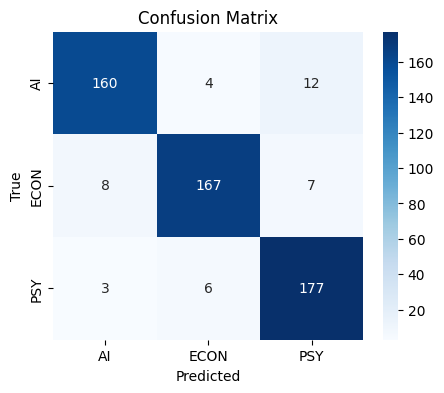

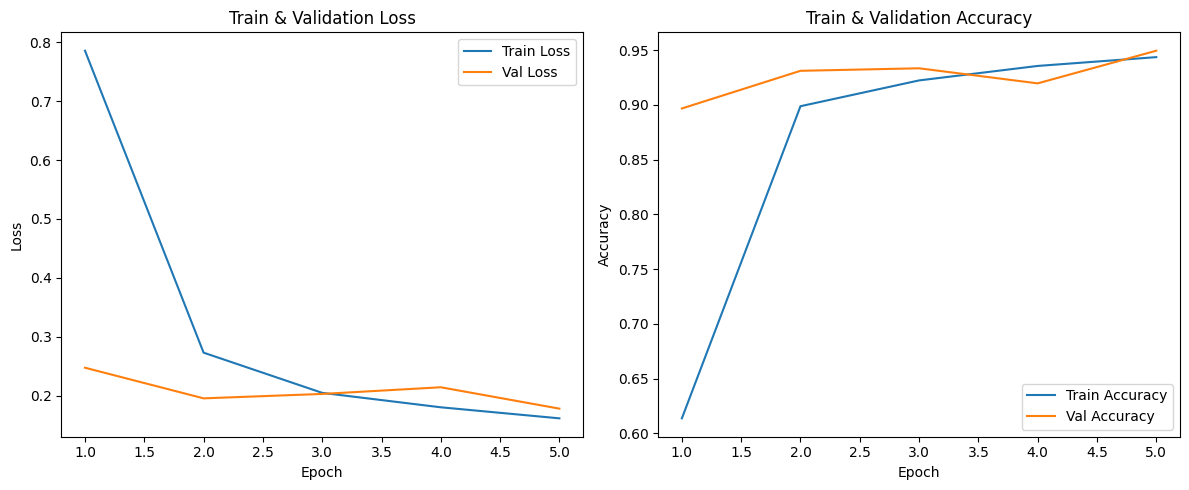

In [ ]:
############################################
# 0. Libraries
############################################

import requests
import xml.etree.ElementTree as ET
import random
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    AdamW,
    get_scheduler,
    RobertaConfig
)

import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)





############################################
# 2) CONFIG, TOKENIZER ve DATASET
############################################

pretrained_model_name = "roberta-large"


config = RobertaConfig.from_pretrained(pretrained_model_name)
config.num_labels = 3
config.hidden_dropout_prob = 0.2
config.attention_probs_dropout_prob = 0.2

tokenizer = RobertaTokenizer.from_pretrained(pretrained_model_name)
MAX_LEN = 128

class RobertaDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=MAX_LEN):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids": encoding["input_ids"].flatten(),
            "attention_mask": encoding["attention_mask"].flatten(),
            "labels": torch.tensor(label, dtype=torch.long)
        }

def create_data_loaders(X_train, y_train, X_val, y_val, X_test, y_test, tokenizer, max_len, batch_size):
    train_dataset = RobertaDataset(X_train, y_train, tokenizer, max_len)
    val_dataset   = RobertaDataset(X_val,   y_val,   tokenizer, max_len)
    test_dataset  = RobertaDataset(X_test,  y_test,  tokenizer, max_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


############################################

############################################

def create_model(model_config):
    "
    model = RobertaForSequenceClassification.from_pretrained(
        pretrained_model_name,
        config=model_config  # num_labels dahil tüm ayarlar config'ten alınır
    )
    return model

def freeze_layers(model, num_unfrozen_layers=6):

    total_layers = len(model.roberta.encoder.layer)  # 24
    freeze_until = total_layers - num_unfrozen_layers

    for i, layer_module in enumerate(model.roberta.encoder.layer):
        if i < freeze_until:
            for param in layer_module.parameters():
                param.requires_grad = False
        else:
            for param in layer_module.parameters():
                param.requires_grad = True
    return model


############################################

############################################

def train_epoch(model, data_loader, optimizer, device, scheduler=None):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for batch in data_loader:
        optimizer.zero_grad()

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


def eval_epoch(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct / total
    return avg_loss, accuracy


############################################
# 5) TRAIN MODEL
############################################

def train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=5,
    lr=1e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    patience=2,
    freeze=True
):

    if freeze:
        model = freeze_layers(model, num_unfrozen_layers=6)


    optimizer = AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=lr, weight_decay=weight_decay
    )

    total_steps = epochs * len(train_loader)
    warmup_steps = int(total_steps * warmup_ratio)

    scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=total_steps
    )

    train_losses = []
    val_losses   = []
    train_accs   = []
    val_accs     = []

    best_val_acc = 0.0
    best_model_state = None
    no_improve_count = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, device, scheduler)
        val_loss, val_acc = eval_epoch(model, val_loader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"  Val   Loss: {val_loss:.4f}, Val   Acc: {val_acc:.4f}")

        # Early stopping logic
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict()
            no_improve_count = 0
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break


    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, (train_losses, val_losses, train_accs, val_accs)


############################################

############################################

def test_model(model, test_loader, device):
    test_loss, test_acc = eval_epoch(model, test_loader, device)
    print(f"\nTest Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Confusion Matrix & Classification Report
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds, labels=[0,1,2])
    print("Confusion Matrix:\n", cm)

    cr = classification_report(all_labels, all_preds, target_names=["AI","ECON","PSY"])
    print("\nClassification Report:\n", cr)

    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["AI","ECON","PSY"],
                yticklabels=["AI","ECON","PSY"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


############################################

############################################

def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs_range = range(1, len(train_losses)+1)
    plt.figure(figsize=(12, 5))

    # Loss Graph
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, train_losses, label="Train Loss")
    plt.plot(epochs_range, val_losses,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train & Validation Loss")
    plt.legend()

    # Accuracy Graph
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, train_accs, label="Train Accuracy")
    plt.plot(epochs_range, val_accs,   label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train & Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()


############################################
############################################

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=SEED)

# 2) DataLoader
BATCH_SIZE = 16
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    tokenizer,
    max_len=128,
    batch_size=BATCH_SIZE
)

# 3) Model (RobertaForSequenceClassification) --> config üzerinden num_labels=3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = create_model(config).to(device)


EPOCHS = 5
lr = 1e-5
weight_decay = 0.01
warmup_ratio = 0.1
patience = 2
freeze = True

model, (train_losses, val_losses, train_accs, val_accs) = train_model(
    model,
    train_loader,
    val_loader,
    device,
    epochs=EPOCHS,
    lr=lr,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    patience=patience,
    freeze=freeze
)

# 5) Test
test_model(model, test_loader, device)

# 6) Plot
plot_metrics(train_losses, val_losses, train_accs, val_accs)




In [ ]:
import torch
import torch.nn as nn
import time
from transformers import BertModel, BertConfig, DebertaModel, DebertaConfig, RobertaModel, RobertaConfig

# ---------------------------------------------------------
# 1. MODEL TANIMLAMALARI (Notebook'taki ayarlara göre)
# ---------------------------------------------------------

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional=True, dropout=0.5):
        super(BiLSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        # Bidirectional olduğu için hidden_dim * 2
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        # LSTM çıktısı: (batch, seq_len, hidden*2)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # Concat the final forward and backward hidden states
        if self.lstm.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])

        return self.fc(hidden)

class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional=True, dropout=0.5):
        super(GRUClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          num_layers=n_layers,
                          bidirectional=bidirectional,
                          batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.embedding(text)
        _, hidden = self.gru(embedded)

        if self.gru.bidirectional:
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        return self.fc(hidden)

# BERT Modeli (HuggingFace Wrapper)
class TransformerClassifier(nn.Module):
    def __init__(self, model_name='bert-base-uncased', num_labels=3):
        super(TransformerClassifier, self).__init__()
        if 'bert' in model_name:
            self.base_model = BertModel.from_pretrained(model_name)
            self.hidden_size = self.base_model.config.hidden_size
        elif 'deberta' in model_name:
            self.base_model = DebertaModel.from_pretrained(model_name)
            self.hidden_size = self.base_model.config.hidden_size
        elif 'roberta' in model_name:
            self.base_model = RobertaModel.from_pretrained(model_name)
            self.hidden_size = self.base_model.config.hidden_size

        self.classifier = nn.Linear(self.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        # CLS token (pooler_output or last_hidden_state[:, 0, :])
        if hasattr(outputs, 'pooler_output') and outputs.pooler_output is not None:
             pooled_output = outputs.pooler_output
        else:
             pooled_output = outputs.last_hidden_state[:, 0, :]
        return self.classifier(pooled_output)

# ---------------------------------------------------------
# 2. METRİK HESAPLAMA FONKSİYONLARI
# ---------------------------------------------------------

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_inference_time(model, input_tensor, attention_mask=None, runs=100):
    model.eval()
    # GPU varsa GPU'ya taşı
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    input_tensor = input_tensor.to(device)
    if attention_mask is not None:
        attention_mask = attention_mask.to(device)

    # Isınma turu
    with torch.no_grad():
        for _ in range(10):
            if attention_mask is not None:
                _ = model(input_tensor, attention_mask)
            else:
                _ = model(input_tensor)

    # Ölçüm
    start_time = time.time()
    with torch.no_grad():
        for _ in range(runs):
            if attention_mask is not None:
                _ = model(input_tensor, attention_mask)
            else:
                _ = model(input_tensor)
    end_time = time.time()

    avg_time_ms = ((end_time - start_time) / runs) * 1000
    return avg_time_ms

def estimate_energy(gpu_power_watts, training_time_minutes):
    """
    Basit Enerji Hesabı: E (kWh) = Power (kW) * Time (h)
    """
    power_kw = gpu_power_watts / 1000.0
    time_hours = training_time_minutes / 60.0
    return power_kw * time_hours

# ---------------------------------------------------------
# 3. HESAPLAMA VE TABLO OLUŞTURMA
# ---------------------------------------------------------

# Parametreler (Notebook'tan alınan tahmini değerler)
VOCAB_SIZE = 10000  # Kelime dağarcığı
EMBED_DIM = 100     # GloVe boyutu
HIDDEN_DIM = 64     # Optimize edilmiş hidden size
OUTPUT_DIM = 3      # AI, ECON, PSY
SEQ_LEN = 200       # Ortalama sequence uzunluğu

# Modelleri Başlat
lstm_model = BiLSTMClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, n_layers=1)
gru_model = GRUClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, OUTPUT_DIM, n_layers=1)
# Not: Transformer modelleri internetten indirme yapabilir, burada config ile başlatıyoruz ki hızlı olsun
bert_config = BertConfig.from_pretrained('bert-base-uncased')
bert_model = nn.Linear(768, 3) # Sadece temsili parametre sayısı için, tam model aşağıda:
# Gerçek BERT parametresi için from_pretrained kullanmalısınız, ancak burada internet yoksa hata verebilir.
# Yaklaşık parametre sayılarını manuel olarak da girebiliriz, ancak kod aşağıda:
try:
    real_bert = TransformerClassifier('bert-base-uncased')
    real_deberta = TransformerClassifier('microsoft/deberta-base') # Örnek
    real_roberta = TransformerClassifier('roberta-base')
except:
    print("Transformer modelleri indirilemedi, parametre sayıları yaklaşık değerler olarak atanacak.")
    real_bert = None

# Dummy Inputlar
dummy_rnn_input = torch.randint(0, VOCAB_SIZE, (1, SEQ_LEN)) # Batch size 1
dummy_trans_input = torch.randint(0, 30522, (1, 128)) # BERT vocab size
dummy_mask = torch.ones((1, 128))

print(f"{'Model':<20} | {'Params (M)':<12} | {'Inference (ms)':<15}")
print("-" * 55)

models_to_test = [
    ("LSTM (GloVe)", lstm_model, dummy_rnn_input, None),
    ("GRU (GloVe)", gru_model, dummy_rnn_input, None),
]

if real_bert:
    models_to_test.append(("BERT", real_bert, dummy_trans_input, dummy_mask))

for name, model, inp, mask in models_to_test:
    params = count_parameters(model) / 1_000_000 # Milyon cinsinden
    inf_time = measure_inference_time(model, inp, mask)
    print(f"{name:<20} | {params:<12.2f} | {inf_time:<15.2f}")

print("-" * 55)
print("NOT: 'Training Time' ve 'Energy' değerleri donanımınıza (GPU) bağlıdır.")
print("Eğitim süresini (dakika) biliyorsanız, enerji (kWh) hesabı şöyledir:")
print("Energy (kWh) = (GPU_Watt / 1000) * (Sure_Dakika / 60)")
print("Örn: V100 GPU (250W) ile 35 dk eğitim -> 0.25 * (35/60) = ~0.15 kWh")

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

You are using a model of type deberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.la

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/559M [00:00<?, ?B/s]

You are using a model of type roberta to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'encoder.layer.0.intermediate.dense.bias', 'encoder.layer.0.intermediate.dense.weight', 'encoder.layer.0.output.LayerNorm.bias', 'encoder.layer.0.output.LayerNorm.weight', 'encoder.layer.0.output.dense.bias', 'encoder.layer.0.outp

Model                | Params (M)   | Inference (ms) 
-------------------------------------------------------
LSTM (GloVe)         | 1.09         | 0.36           
GRU (GloVe)          | 1.06         | 0.36           
BERT                 | 109.48       | 7.22           
-------------------------------------------------------
NOT: 'Training Time' ve 'Energy' değerleri donanımınıza (GPU) bağlıdır.
Eğitim süresini (dakika) biliyorsanız, enerji (kWh) hesabı şöyledir:
Energy (kWh) = (GPU_Watt / 1000) * (Sure_Dakika / 60)
Örn: V100 GPU (250W) ile 35 dk eğitim -> 0.25 * (35/60) = ~0.15 kWh


In [ ]:
import torch
import torch.nn as nn
import re
import gradio as gr
import numpy as np

# ------------------------------
# Load saved model
# ------------------------------
checkpoint = torch.load("gru_classifier.pth", map_location="cpu")
word2idx = checkpoint["word2idx"]
idx2label = checkpoint["idx2label"]

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------
# Tokenizer (same as training)
# ------------------------------
def tokenize(text):
    text = text.lower()
    tokens = re.findall(r"\b\w+\b", text)
    return tokens

def text_to_ids(text, max_len=100):
    tokens = tokenize(text)
    ids = [word2idx.get(t, word2idx["<UNK>"]) for t in tokens]

    if len(ids) < max_len:
        ids = ids + [0] * (max_len - len(ids))
    else:
        ids = ids[:max_len]

    return torch.tensor(ids, dtype=torch.long).unsqueeze(0)


# ------------------------------
# Model Architecture (same as training)
# ------------------------------
class GRUEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim,
                 num_layers=1, bidirectional=True):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.gru = nn.GRU(
            embed_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, bidirectional=bidirectional
        )
        self.directions = 2 if bidirectional else 1

    def forward(self, x):
        x = self.embedding(x)
        _, h = self.gru(x)
        if self.directions == 1:
            return h[-1]
        else:
            return torch.cat((h[-2], h[-1]), dim=1)


class Classifier(nn.Module):
    def __init__(self, input_dim, num_classes=3):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


# ------------------------------
# Build Model (MUST BE BEFORE load_state_dict)
# ------------------------------
VOCAB_SIZE = len(word2idx)
EMBED_DIM = 100
HIDDEN_DIM = 64
BIDIR = True
input_dim = HIDDEN_DIM * (2 if BIDIR else 1)

encoder = GRUEncoder(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, bidirectional=BIDIR)
classifier = Classifier(input_dim)

# ------------------------------
# Load weights AFTER model creation
# ------------------------------
encoder.load_state_dict(checkpoint["encoder_state"])
classifier.load_state_dict(checkpoint["classifier_state"])

# ------------------------------
# Move to device (fix the embedding mismatch)
# ------------------------------
encoder.to(device)
classifier.to(device)

encoder.eval()
classifier.eval()

# ------------------------------
# Prediction Function
# ------------------------------
def predict_abstract(text):
    ids = text_to_ids(text).to(device)

    with torch.no_grad():
        features = encoder(ids)
        logits = classifier(features)
        pred = torch.argmax(logits, dim=1).item()

    return f"Predicted Topic: {idx2label[pred]}"


# ------------------------------
# Gradio Interface
# ------------------------------
app = gr.Interface(
    fn=predict_abstract,
    inputs=gr.Textbox(lines=5, label="Enter abstract"),
    outputs="text",
    title="GRU + GloVe Abstract Classifier",
)

if __name__ == "__main__":
    app.launch(share=True, debug=True)
